# Improving Ocean Mixing Parameterizations through Neural Networks Trained on Physically-Informed and Clustered Surface Forcing Regimes



Vertical mixing in the ocean surface boundary layer (OSBL) plays a critical role in regulating climate-relevant processes, such as the exchange of heat, carbon, and nutrients between the atmosphere and ocean interior. However, the representation of vertical mixing in large-scale ocean models remains a key source of uncertainty, particularly due to challenges in parameterizing sub-grid scale turbulence and the shape of vertical diffusivity profiles. This notebook extends the analysis carried out by **Sane et al. (2023)** "Parameterizing vertical mixing coefficients in the ocean surface boundary layer using neural networks" by implementing a **conditional modeling approach based on clustered ocean states**.

## Motivation

The original paper demonstrated that neural networks can effectively predict vertical mixing shapes in the ocean. However, we hypothesize that **different ocean states might benefit from specialized models**. By clustering the input feature space, we can potentially develop models that are better tailored to specific oceanic conditions, further improving prediction accuracy.

The Sane et al. paper trains one neural network on physics informed modeled ocean parameters, including Ocean depth, Coriolis, surface friction velocity, and surface buoyancy flux. Although the shape function described in the Sane et al. paper improves upon the non-physics informed parameterizations in prior global climate models, error still exists. In particular, the network derived shape function exhibits poor performance in representing mixing at nodes that have multi-modal structures (nodes 10-12).

## Approach

1. **Physics-Informed Clustering Approach:** We apply k-means clustering to the model input features—namely the Coriolis parameter, buoyancy flux, friction velocity, and mixed layer depth—in order to identify physically distinct regimes of boundary layer mixing. For each cluster, a separate neural network is trained to learn a cluster-specific shape function. This approach is designed to capture heterogeneity in vertical mixing processes by tailoring the parameterization to physical ocean conditions.

2. **Shape-Based Clustering Approach:** Alternatively, we cluster directly on the shape functions themselves to identify distinct vertical mixing profiles regardless of their associated physical drivers. We then train a classifier to predict the shape cluster from physical parameters and evaluate the resulting predictive performance. This approach aims to learn more coherent and internally consistent shape functions and assess whether shape-level structure can be linked back to observable oceanic features.

## Expected Outcomes

- Identification of distinct oceanic regimes with different mixing behaviors
- Improved prediction accuracy, especially in regions with complex dynamics
- Better understanding of how different physical drivers influence mixing in different regimes

# 1. First Approach: Cluster-Based Parameterization of Vertical Mixing Coefficients

Ocean vertical mixing is driven by a wide range of dynamic and nonlinear interactions, which vary significantly across different oceanic conditions. Relying on a single, universal neural network to predict mixing behavior assumes homogeneity in ocean states, an assumption that can fail in practice. To address this, we adopt a cluster-based parameterization strategy: dividing the data into subsets that represent distinct regimes of ocean forcing conditions and training a dedicated model for each. This approach allows the model to specialize in a narrower, more consistent distribution of inputs, leading to improved generalization, reduced prediction error, and better alignment with the physical variability of the ocean

## 1.1 Loading and Preprocessing GOTM Data

Here we'll load the GOTM (General Ocean Turbulence Model) data provided by Sane et al. (2023) and apply the same preprocessing steps.

In [1]:
%%capture
import importlib

# Check and install required packages
if importlib.util.find_spec("torch") is None:
    !pip install torch
if importlib.util.find_spec("zarr") is None:
    !pip install zarr
if importlib.util.find_spec("scikit-learn") is None:
    !pip install scikit-learn

# Ensure xarray is upgraded
!pip install --upgrade xarray

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
import torch.utils.data as Data
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import xarray as xr
import netCDF4 as ncd
import requests
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.font_manager
from matplotlib.gridspec import GridSpec
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from scipy import stats
import multiprocessing as mp
import time
from datetime import datetime
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Setup notebook environment
today = datetime.today()
np.random.seed(100)
torch.manual_seed(100)

# Fix paths
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# Import custom modules
import lib.func_file as ff
import lib.var_func_file as vff
from lib.visual_figure4 import performance_sigma_point
from lib.visual_figure3 import score_eval, save_losses_by_seed, plot_n1_scores
from lib.cluster_visualizations import (
    plot_cluster_distributions,
    plot_shape_functions_by_cluster,
    plot_cluster_size_distribution,
    plot_cluster_centers,
    plot_model_performance_comparison,
    plot_sample_predictions,
    plot_error_distributions,
    plot_overall_performance_comparison
)

# Set up directories
cwd_data = cwd + '/data/'
cwd_output = cwd + '/output/'
os.makedirs(cwd_output, exist_ok=True)

# Clear any existing CUDA cache
torch.cuda.empty_cache()

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Current working directory: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization
Using device: cuda


In [3]:
# Load GOTM training data produced by Sane et al. 2023
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# Coriolis parameter calculation
def corio(lat):
    return 2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

# Extract variables
l0 = corio(d['l'][:])
b00 = d['b0'][:]
ustar0 = d['ustar'][:]
h0 = d['h'][:]
lat0 = d['lat'][:]
heat0 = d['heat'][:]
tx0 = d['tx'][:]
tx0 = np.round(tx0, 2)
SF0 = d['SF'][:]

# Print summary of input shape
print(f"Data shape: {SF0.shape}, representing {SF0.shape[0]} samples with {SF0.shape[1]} vertical levels")

Data shape: (1335185, 16), representing 1335185 samples with 16 vertical levels


## 1.2 Visualization of how neural network variables differ across various levels of latitude and heat, and wind

- latitude: polar (latitude >= 66.5), midlat (latitude btwn 23.4 & 66.5), and tropical (latitude <=23.4)
- heat: high abs(>=150) low abs(<150) and by negative and positive
- wind: low (<1) and high (>=1)

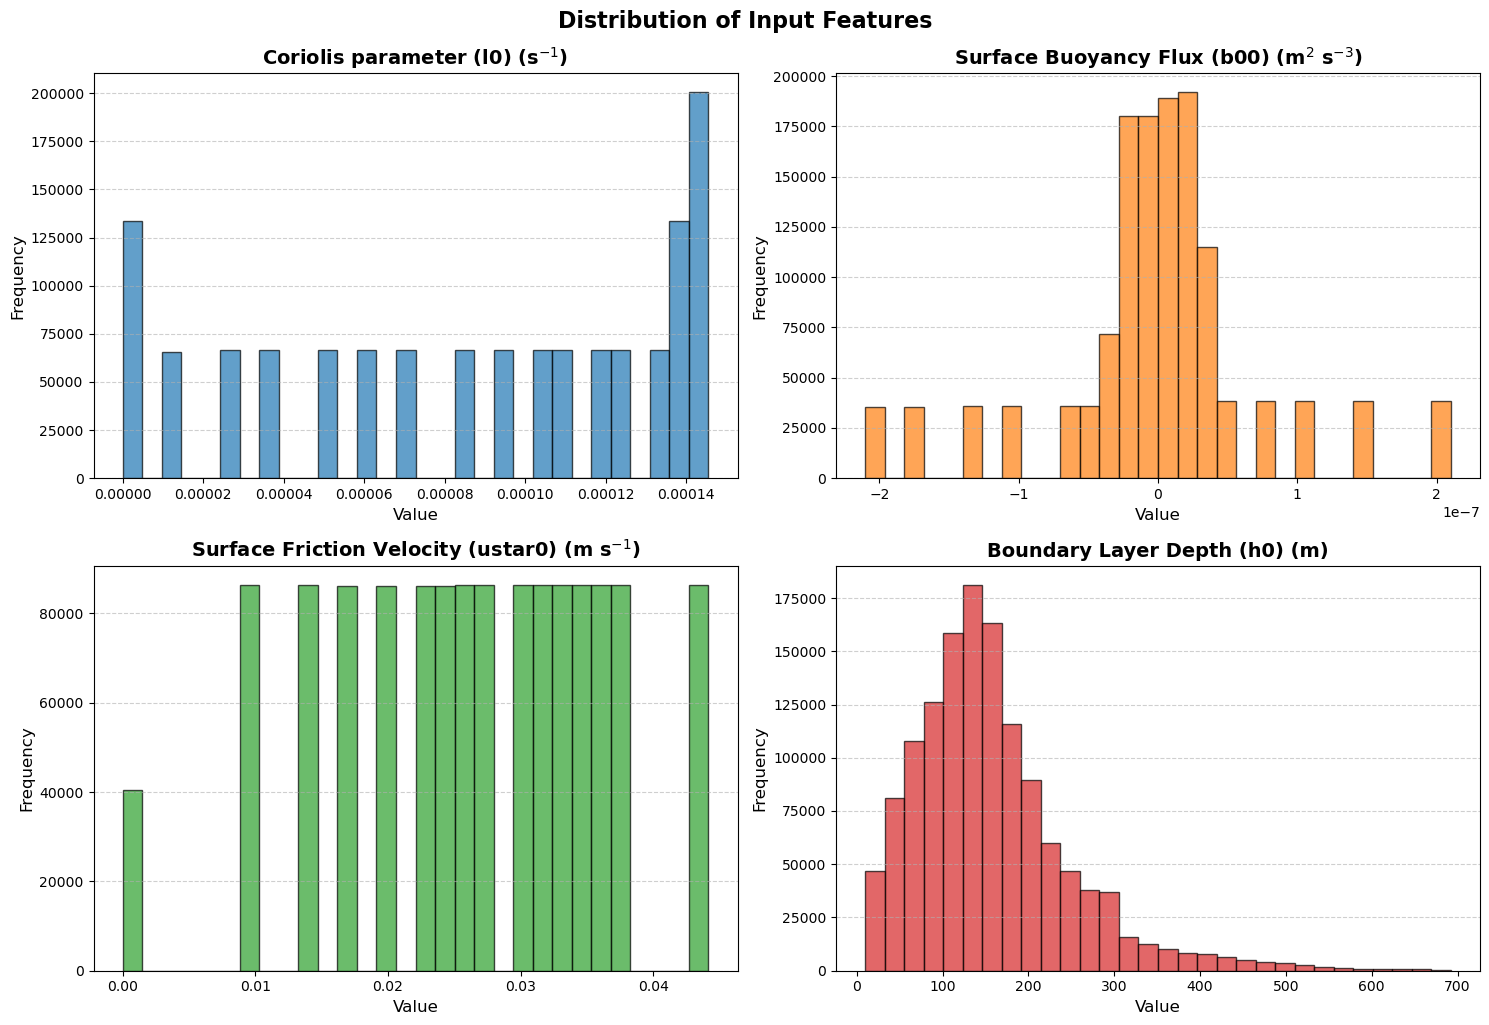

In [4]:
# Quick visualization of input features
variables = {
    "Coriolis parameter (l0) (s$^{-1}$)": l0.values.flatten(),
    "Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": b00.values.flatten(),
    "Surface Friction Velocity (ustar0) (m s$^{-1}$)": ustar0.values.flatten(),
    "Boundary Layer Depth (h0) (m)": h0.values.flatten()
}

# Create histograms with improved styling
plt.figure(figsize=(15, 10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, (name, data) in enumerate(variables.items()):
    plt.subplot(2, 2, i + 1)
    plt.hist(data, bins=30, color=colors[i], alpha=0.7, edgecolor='black')
    plt.title(name, fontsize=14, fontweight='bold')
    plt.xlabel("Value", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.suptitle("Distribution of Input Features", fontsize=16, fontweight='bold', y=1.02)
plt.show()

In [5]:
d_polar = d.where(d.lat >= 66.5)
d_midlat = d.where((d.lat < 66.5) & (d.lat>23.4))
d_tropic = d.where(d.lat <= 23.4)

d_hp = d.where(d.heat >= 150)
d_lp = d.where((d.heat < 150) & (d.heat>0))
d_hn = d.where(d.heat <= -150)
d_ln = d.where((d.heat > -150) & (d.heat<0))

d_lw = d.where(d.tx < 1)
d_hw = d.where(d.tx >= 1)

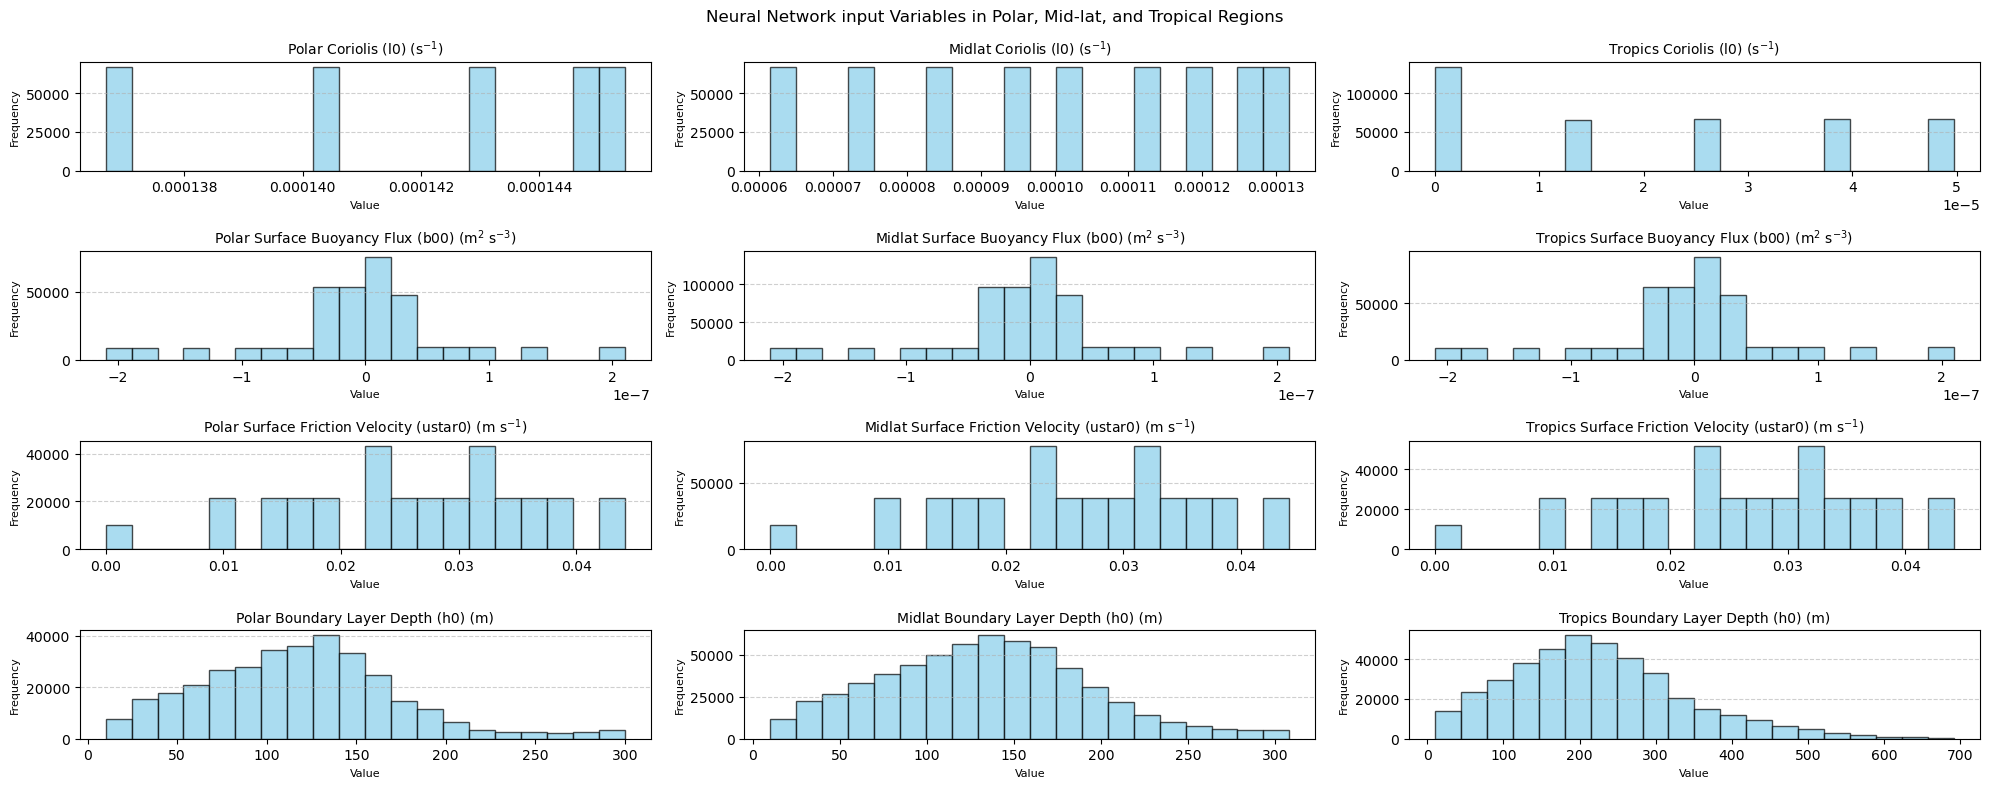

In [6]:
variables_latitude = { 
    "Polar Coriolis (l0) (s$^{-1}$)": corio(d_polar['l'][:]).values.flatten(),
    "Midlat Coriolis (l0) (s$^{-1}$)": corio(d_midlat['l'][:]).values.flatten(),
    "Tropics Coriolis (l0) (s$^{-1}$)": corio(d_tropic['l'][:]).values.flatten(),
    "Polar Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": d_polar['b0'][:].values.flatten(),
    "Midlat Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": d_midlat['b0'][:].values.flatten(),
    "Tropics Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": d_tropic['b0'][:].values.flatten(),
    "Polar Surface Friction Velocity (ustar0) (m s$^{-1}$)": d_polar['ustar'][:].values.flatten(),
    "Midlat Surface Friction Velocity (ustar0) (m s$^{-1}$)": d_midlat['ustar'][:].values.flatten(),
    "Tropics Surface Friction Velocity (ustar0) (m s$^{-1}$)": d_tropic['ustar'][:].values.flatten(),
    "Polar Boundary Layer Depth (h0) (m)": d_polar['h'][:].values.flatten(),
    "Midlat Boundary Layer Depth (h0) (m)": d_midlat['h'][:].values.flatten(),
    "Tropics Boundary Layer Depth (h0) (m)": d_tropic['h'][:].values.flatten(),
}

# Plot histograms for the input variables
plt.figure(figsize=(20, 8))
for i, (name, data) in enumerate(variables_latitude.items()):
    plt.subplot(4, 3, i + 1)
    plt.hist(data, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
    plt.title(name, fontsize=10)
    plt.xlabel("Value", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.suptitle("Neural Network input Variables in Polar, Mid-lat, and Tropical Regions")
plt.tight_layout()
plt.show()

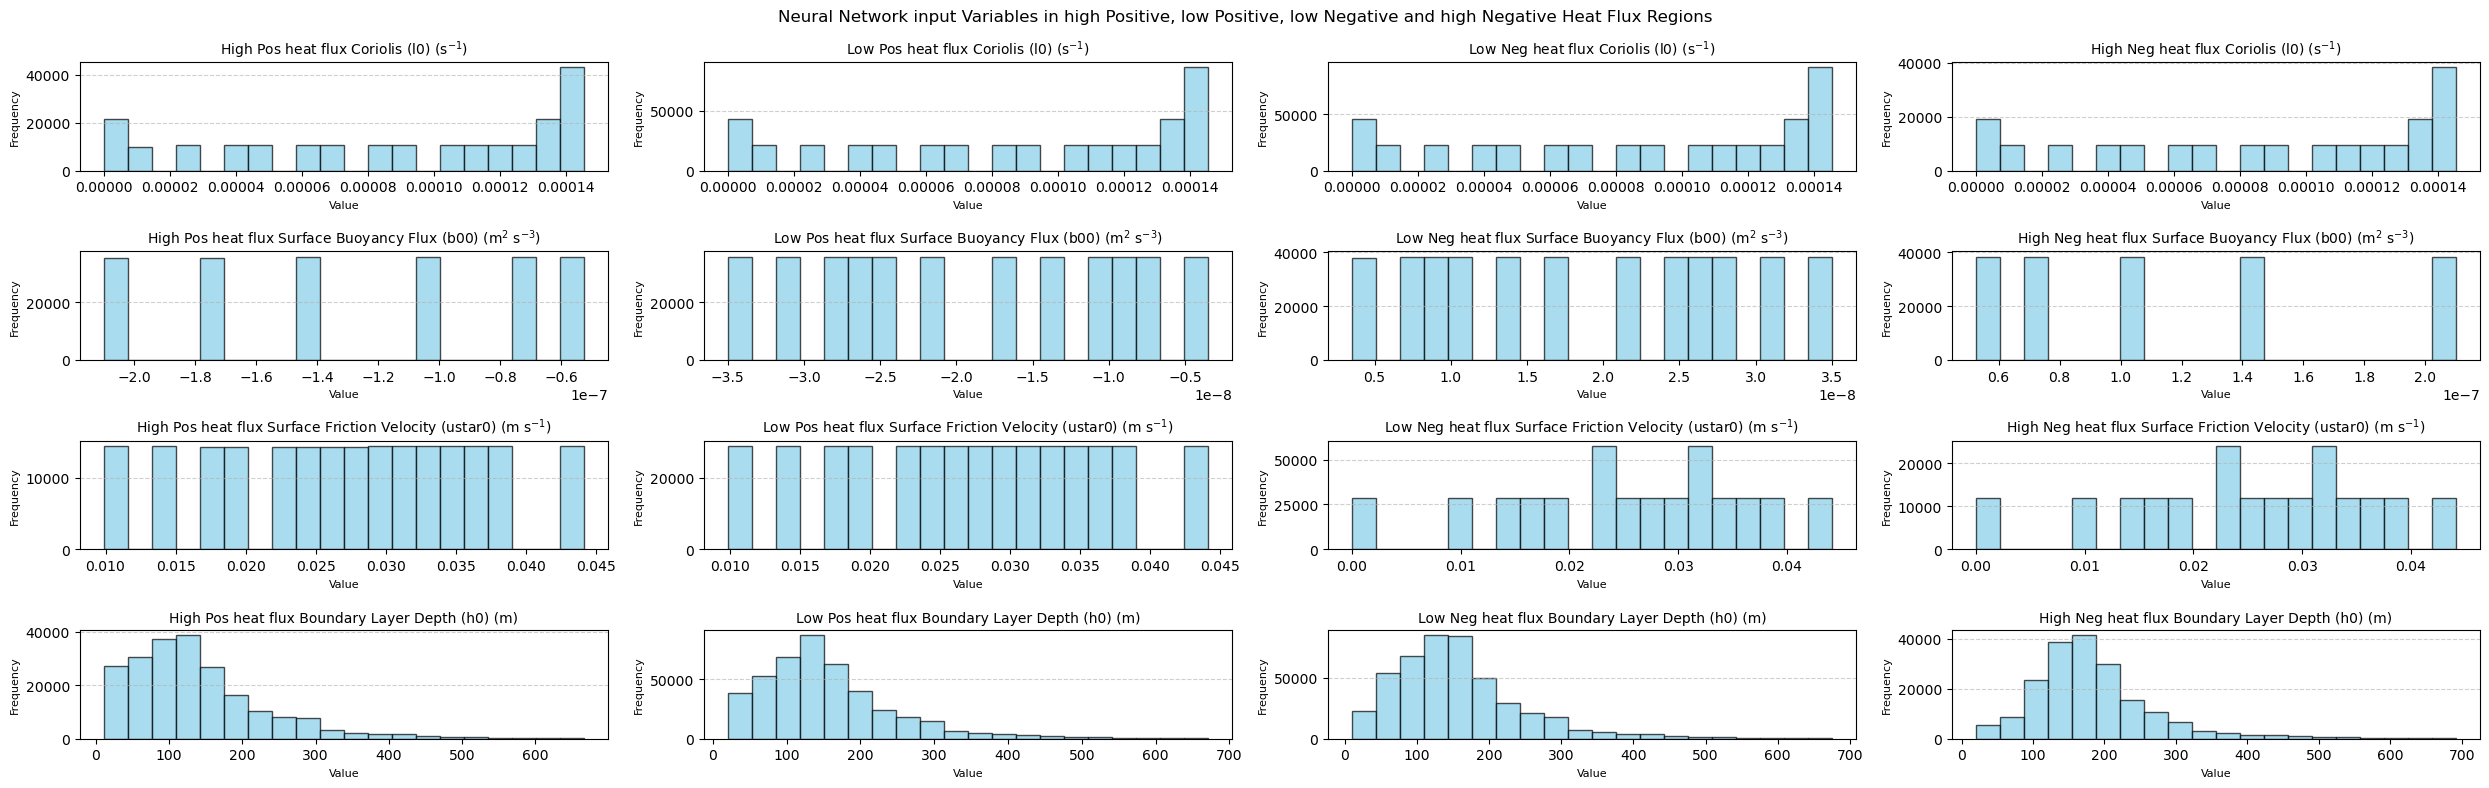

In [7]:
variables_heat_flux = { 
    "High Pos heat flux Coriolis (l0) (s$^{-1}$)": corio(d_hp['l'][:]).values.flatten(),
    "Low Pos heat flux Coriolis (l0) (s$^{-1}$)": corio(d_lp['l'][:]).values.flatten(),
    "Low Neg heat flux Coriolis (l0) (s$^{-1}$)": corio(d_ln['l'][:]).values.flatten(),
    "High Neg heat flux Coriolis (l0) (s$^{-1}$)": corio(d_hn['l'][:]).values.flatten(),
    "High Pos heat flux Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": d_hp['b0'][:].values.flatten(),
    "Low Pos heat flux Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": d_lp['b0'][:].values.flatten(),
    "Low Neg heat flux Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": d_ln['b0'][:].values.flatten(),
    "High Neg heat flux Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": d_hn['b0'][:].values.flatten(),
    "High Pos heat flux Surface Friction Velocity (ustar0) (m s$^{-1}$)": d_hp['ustar'][:].values.flatten(),
    "Low Pos heat flux Surface Friction Velocity (ustar0) (m s$^{-1}$)": d_lp['ustar'][:].values.flatten(),
    "Low Neg heat flux Surface Friction Velocity (ustar0) (m s$^{-1}$)": d_ln['ustar'][:].values.flatten(),
    "High Neg heat flux Surface Friction Velocity (ustar0) (m s$^{-1}$)": d_hn['ustar'][:].values.flatten(),
    "High Pos heat flux Boundary Layer Depth (h0) (m)": d_hp['h'][:].values.flatten(),
    "Low Pos heat flux Boundary Layer Depth (h0) (m)": d_lp['h'][:].values.flatten(),
    "Low Neg heat flux Boundary Layer Depth (h0) (m)": d_ln['h'][:].values.flatten(),
    "High Neg heat flux Boundary Layer Depth (h0) (m)": d_hn['h'][:].values.flatten(),
}

# Plot histograms for the input variables
plt.figure(figsize=(25, 8))
for i, (name, data) in enumerate(variables_heat_flux.items()):
    plt.subplot(4, 4, i + 1)
    plt.hist(data, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
    plt.title(name, fontsize=10)
    plt.xlabel("Value", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.suptitle("Neural Network input Variables in high Positive, low Positive, low Negative and high Negative Heat Flux Regions")
plt.tight_layout()
plt.show()

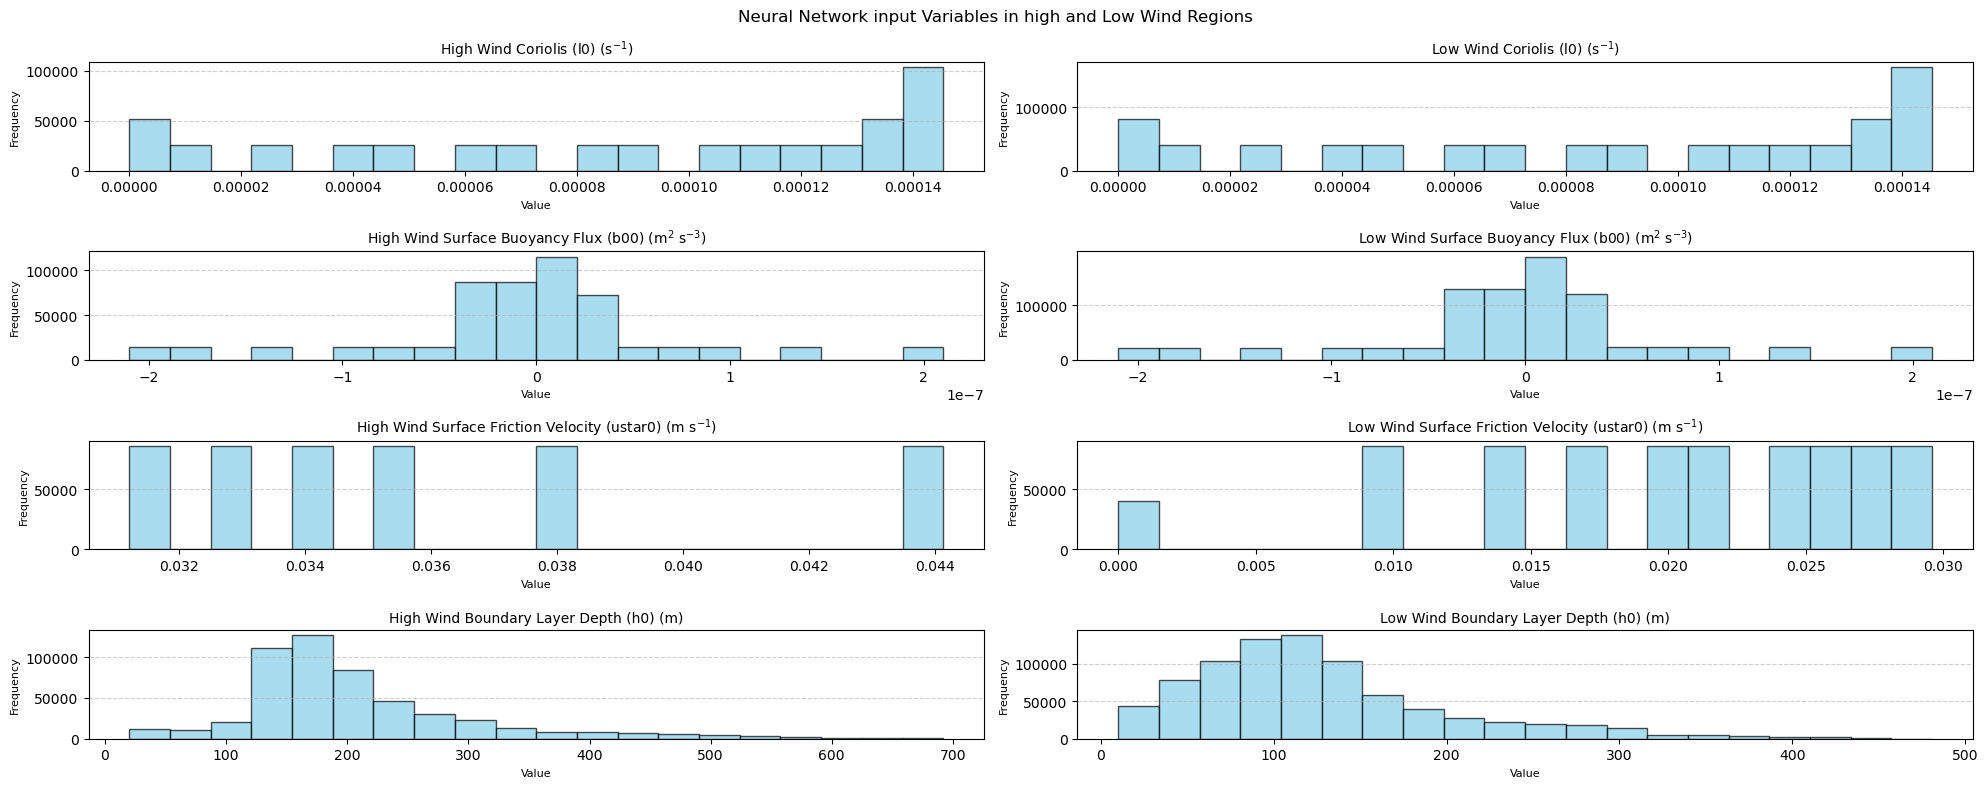

In [8]:
variables_wind = { 
    "High Wind Coriolis (l0) (s$^{-1}$)": corio(d_hw['l'][:]).values.flatten(),
    "Low Wind Coriolis (l0) (s$^{-1}$)": corio(d_lw['l'][:]).values.flatten(),
    "High Wind Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": d_hw['b0'][:].values.flatten(),
    "Low Wind Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": d_lw['b0'][:].values.flatten(),
    "High Wind Surface Friction Velocity (ustar0) (m s$^{-1}$)": d_hw['ustar'][:].values.flatten(),
    "Low Wind Surface Friction Velocity (ustar0) (m s$^{-1}$)": d_lw['ustar'][:].values.flatten(),
    "High Wind Boundary Layer Depth (h0) (m)": d_hw['h'][:].values.flatten(),
    "Low Wind Boundary Layer Depth (h0) (m)": d_lw['h'][:].values.flatten(),
}

# Plot histograms for the input variables
plt.figure(figsize=(20, 8))
for i, (name, data) in enumerate(variables_wind.items()):
    plt.subplot(4, 2, i + 1)
    plt.hist(data, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
    plt.title(name, fontsize=10)
    plt.xlabel("Value", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.suptitle("Neural Network input Variables in high and Low Wind Regions")
plt.tight_layout()
plt.show()

#### Visual Findings
- Surface buoyancy is similar across different latitude, heat and wind groupings
- Coriolis decreases the closer to the equator
- Surface friction doesn't differ by latitude and heat flux; Surface friction is higher for higher winds
- Boundary layer is greater for tropics than mid-lat & polar. Boundary layer is a function of u*/coriolis. Therefore, as coriolis approaches 0 at the equator, this boundary number increases. 

## 1.3 Preprocessing and Normalization of each subset

Prepare training and validation data for a neural network that will predict the vertical mixing shape function in the ocean surface boundary layer. This follows the same data preprocessing approach used in Sane et al.


In [9]:
# Apply the same filtering criteria as in Sane et al. (2023)
ind101 = np.where(np.abs(heat0) < 601)[0]
ind1 = ind101
ind2 = np.where(tx0 < 1.2)[0]
ind3 = np.where(h0 > 29)[0]
ind4 = np.where(h0 < 301)[0]

# Combine all filters
ind5 = np.intersect1d(ind1, ind2)
ind6 = np.intersect1d(ind3, ind5)
ind7 = np.intersect1d(ind4, ind6)

# Prepare data for model training
mm1 = 0; mm2 = 16  # 16 levels (level 1 at bottom, level 16 at top)
data_load_main = np.zeros([len(h0[ind7]), 4 + mm2 - mm1])
data_load_main[:, 0] = l0[ind7]     # Coriolis parameter
data_load_main[:, 1] = b00[ind7]    # Surface buoyancy flux
data_load_main[:, 2] = ustar0[ind7] # Surface friction velocity
data_load_main[:, 3] = h0[ind7]     # Boundary layer depth
data_load_main[:, 4:(mm2 - mm1 + 4)] = SF0[ind7, mm1:mm2] # Shape functions

# Store additional forcing variables for reference
data_forc = np.zeros([len(ind7), 3])
data_forc[:, 0] = lat0[ind7]  # Latitude
data_forc[:, 1] = heat0[ind7] # Heat flux
data_forc[:, 2] = tx0[ind7]   # Wind stress

# Create a copy of the data for processing
data_load3 = copy.deepcopy(data_load_main)

# Preprocess data using the same function as in the original code
print('Preprocessing data...')
data, x, y, stats, k_mean, k_std = ff.preprocess_train_data(data_load3)
print('Done preprocessing')

Preprocessing data...
Done preprocessing


In [10]:
# Load validation data
url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df = pd.read_csv(url, delim_whitespace=True, header=None)
valid_data = df.iloc[:, 3:].values

# Apply same filtering criteria
ind3 = np.where(valid_data[:, 3] > 29)[0]
ind4 = np.where(valid_data[:, 3] < 301)[0]
ind = np.intersect1d(ind3, ind4)

# Extract and normalize validation features
valid_x = valid_data[ind, 0:4]
valid_x[:, 0] = (valid_x[:, 0] - stats[0]) / stats[1]  # Normalize Coriolis
valid_x[:, 1] = (valid_x[:, 1] - stats[2]) / stats[3]  # Normalize buoyancy flux
valid_x[:, 2] = (valid_x[:, 2] - stats[4]) / stats[5]  # Normalize friction velocity
valid_x[:, 3] = (valid_x[:, 3] - stats[6]) / stats[7]  # Normalize layer depth

# Extract and normalize validation targets
valid_y = valid_data[ind, 5:]
for i in range(len(valid_y)):
    valid_y[i, :] = np.log(valid_y[i, :] / np.max(valid_y[i, :]))
for i in range(16):
    valid_y[:, i] = (valid_y[:, i] - k_mean[i]) / k_std[i]

# Convert to PyTorch tensors
x = torch.FloatTensor(x).to(device)
y = torch.FloatTensor(y).to(device)
valid_x = torch.FloatTensor(valid_x).to(device)
valid_y = torch.FloatTensor(valid_y).to(device)

print(f"Training data shape: {x.shape}, {y.shape}")
print(f"Validation data shape: {valid_x.shape}, {valid_y.shape}")

Training data shape: torch.Size([917858, 4]), torch.Size([917858, 16])
Validation data shape: torch.Size([89899, 4]), torch.Size([89899, 16])


## 1.4 Define the Neural Network Model

We'll use the same architecture as in the original paper: a multilayer perceptron with 2 hidden layers and 32 neurons per layer. We train one neural network per subset.

In [11]:
class OceanMixingNN(nn.Module):
    def __init__(self, in_nodes, hidden_nodes, out_nodes):
        super(OceanMixingNN, self).__init__()
        self.linear1 = nn.Linear(in_nodes, hidden_nodes)
        self.linear2 = nn.Linear(hidden_nodes, hidden_nodes)
        self.linear3 = nn.Linear(hidden_nodes, out_nodes)
        self.dropout = nn.Dropout(0.25)  # Regularization
        
        # Initialize weights using the same approach as in original paper
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.linear3.weight)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        return self.linear3(x)

In [12]:
def train_model(model, x, y, valid_x, valid_y, k_mean, k_std, epochs=3000, lr=1e-3, patience=50):
    """Train a model with early stopping based on validation loss"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.L1Loss(reduction='mean')
    losses = []
    
    # Convert k_mean and k_std to tensors on appropriate device
    k_mean_tensor = torch.tensor(k_mean, dtype=torch.float32).to(device)
    k_std_tensor = torch.tensor(k_std, dtype=torch.float32).to(device)
    
    # For early stopping
    best_loss = float('inf')
    best_model = None
    no_improve = 0
    
    with tqdm(total=epochs, desc="Training") as pbar:
        for epoch in range(epochs):
            # Training step
            model.train()
            optimizer.zero_grad()
            
            # Forward pass
            train_pred = model(x)
            
            # Compute loss (same as in original paper)
            loss = loss_fn(train_pred, y)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            # Validation
            model.eval()
            with torch.no_grad():
                valid_pred = model(valid_x)
                
                # Calculate loss in original space, not normalized space
                train_loss = torch.mean(torch.abs(
                    torch.exp(train_pred * k_std_tensor + k_mean_tensor) - 
                    torch.exp(y * k_std_tensor + k_mean_tensor)
                ))
                
                valid_loss = torch.mean(torch.abs(
                    torch.exp(valid_pred * k_std_tensor + k_mean_tensor) - 
                    torch.exp(valid_y * k_std_tensor + k_mean_tensor)
                ))
            
            # Store losses
            losses.append((epoch, train_loss.item(), valid_loss.item()))
            
            # Update progress bar
            pbar.update(1)
            pbar.set_postfix({
                'train_loss': f"{train_loss.item():.4f}", 
                'valid_loss': f"{valid_loss.item():.4f}",
                'patience': no_improve
            })
            
            # Early stopping
            if valid_loss.item() < best_loss:
                best_loss = valid_loss.item()
                best_model = copy.deepcopy(model.state_dict())
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"\nEarly stopping at epoch {epoch+1}")
                    break
    
    # Load the best model
    if best_model is not None:
        model.load_state_dict(best_model)
    
    return model, np.array(losses)

## 1.5 Train the Baseline Model

We train a baseline neural network that tries to learn a single mapping from surface forcing conditions to the vertical mixing shape function across all ocean parameters. This will act as our control model. 

In [13]:
# Define model parameters
in_nodes = 4      # 4 input features
hidden_nodes = 32 # 32 nodes per hidden layer
out_nodes = 16    # 16 output points (one for each sigma level)

# Initialize and train the baseline model
print("Training baseline model on all data...")
baseline_model = OceanMixingNN(in_nodes, hidden_nodes, out_nodes).to(device)
baseline_model, baseline_losses = train_model(
    baseline_model, x, y, valid_x, valid_y, k_mean, k_std
)

Training baseline model on all data...


Training:  45%|████▌     | 1351/3000 [00:44<00:54, 30.20it/s, train_loss=0.0373, valid_loss=0.0478, patience=49]



Early stopping at epoch 1351


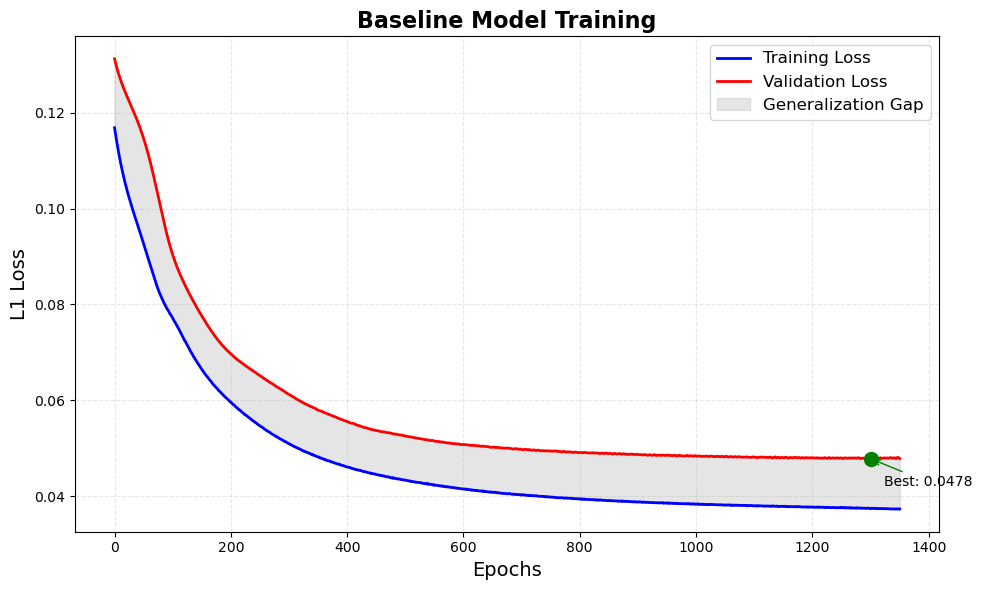

In [14]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
epochs = baseline_losses[:, 0]
train_loss = baseline_losses[:, 1]
valid_loss = baseline_losses[:, 2]

plt.plot(epochs, train_loss, 'b-', linewidth=2, label='Training Loss')
plt.plot(epochs, valid_loss, 'r-', linewidth=2, label='Validation Loss')
plt.fill_between(epochs, train_loss, valid_loss, alpha=0.2, color='gray', label='Generalization Gap')

# Add the best validation loss
best_epoch = np.argmin(valid_loss)
best_valid = valid_loss[best_epoch]
plt.scatter(epochs[best_epoch], best_valid, c='g', s=100, zorder=3)
plt.annotate(f'Best: {best_valid:.4f}', 
             (epochs[best_epoch], best_valid),
             xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='green'))

plt.grid(True, alpha=0.3, linestyle='--')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('L1 Loss', fontsize=14)
plt.title('Baseline Model Training', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Visual results:
- smooth convergence
- small generalization gap
- well-regularized model

In [15]:
# Load GOTM training data produced by Sane et al. 2023
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# Coriolis parameter calculation
def corio(lat):
    return 2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

# Extract variables
l0 = corio(d['l'][:])
b00 = d['b0'][:]
ustar0 = d['ustar'][:]
h0 = d['h'][:]
lat0 = d['lat'][:]
heat0 = d['heat'][:]
tx0 = d['tx'][:]
tx0 = np.round(tx0, 2)
SF0 = d['SF'][:]

# Print summary of input shape
print(f"Data shape: {SF0.shape}, representing {SF0.shape[0]} samples with {SF0.shape[1]} vertical levels")



Data shape: (1335185, 16), representing 1335185 samples with 16 vertical levels


In [16]:
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/raw_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

h=d['h'][:]
h_ind1=np.where(h>10)[0]
h_ind2=np.where(h<700)[0]
h_ind=np.intersect1d(h_ind1,h_ind2)
sf1=d['SF'][h_ind,:]
sf1=sf1[237945:237945+5000,:] # randomly selected few profiles.

sf=np.zeros([len(sf1),16])

sf1 = sf1.values if hasattr(sf1, "values") else sf1
sf = sf1 / np.max(sf1, axis=1, keepdims=True)

# Open the dataset from Sane et al. 2023, here stored on the cloud, accessible on LEAP-Pangeo
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# this function calculates the coriolis parameter from input latitude 
# 2*Omega*sin(lat), where Omega is the Earth's rotation in 1/s
def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:] 
tx0=np.round(tx0,2)
SF0=d['SF'][:] 




In [17]:
def validation_new(x, y):
    x, x_test, y, y_test = train_test_split(x, y, test_size=0.2)
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    x_test=torch.FloatTensor(x_test).to(device)
    y_test=torch.FloatTensor(y_test).to(device)

    return x, x_test, y, y_test
    

In [18]:
def validate_data(x,y):
    url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
    df = pd.read_csv(url, delim_whitespace=True, header = None)  
    valid_data = df.iloc[:, 3:].values 

    ind3=np.where(valid_data[:,3]>29)[0]
    ind4=np.where(valid_data[:,3]<301)[0]
    ind=np.intersect1d(ind3,ind4)

    valid_x=valid_data[ind,0:4]

    valid_x[:,0]=(valid_x[:,0]-stats[0])/stats[1]
    valid_x[:,1]=(valid_x[:,1]-stats[2])/stats[3]
    valid_x[:,2]=(valid_x[:,2]-stats[4])/stats[5]
    valid_x[:,3]=(valid_x[:,3]-stats[6])/stats[7]
    k_mean_test=np.zeros(16)
    valid_y=valid_data[ind,5:]

    for i in range(len(valid_y)):
        valid_y[i,:]=np.log(valid_y[i,:]/np.max(valid_y[i,:]))

    for i in range(16):
        valid_y[:,i]=(valid_y[:,i]-k_mean[i])/k_std[i]

    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    valid_x=torch.FloatTensor(valid_x).to(device)
    valid_y=torch.FloatTensor(valid_y).to(device)

    return x, valid_x, y, valid_y

## 1.6 Splitting data based on parameters prior to running Neural Network

Before training individual neural networks for each parameter, we must first split the data in latitude, heat flux, and wind stress.

In [19]:
data, x, y, stats, k_mean, k_std  = vff.train_model(d, 'paper')
data_l, x_l, y_l, stats_l, k_mean_l, k_std_l  = vff.train_model(d, 'lat')
data_h, x_h, y_h, stats_h, k_mean_h, k_std_h  = vff.train_model(d, 'heat')
data_w, x_w, y_w, stats_w, k_mean_w, k_std_w  = vff.train_model(d, 'wind')
data_a, x_a, y_a, stats_a, k_mean_a, k_std_a  = vff.train_model(d, 'all')

started paper model
started model with latitude
started model with heat
started model with wind
started all data


In [20]:
x, valid_x, y, valid_y = validate_data(x, y)
x_l, x_test_l, y_l, y_test_l = validation_new(x_l, y_l)
x_h, x_test_h, y_h, y_test_h = validation_new(x_h, y_h)
x_w, x_test_w, y_w, y_test_w = validation_new(x_w, y_w)
x_a, x_test_a, y_a, y_test_a = validation_new(x_a, y_a)

In [21]:
# Loss weighting option here, all weights = 1.0 in default run 
# Weight settings here
kms1=1.0 
kms2=1.0
# Weight per node set here. Set weights to kms1 or to kms2 to use values above
k16 = kms1; k15 = kms1; k14 = kms1; k13 = kms1; k12 = kms1; k11 = kms1; 
k10 = kms1; k9 = kms1; k8 = kms1; k7 = kms1; k6 = kms1; k5 = kms1; 
k4 = kms1; k3 = kms1; k2 = kms1; k1 = kms1; 
# Weight for each layer. 
# ARRANGED FROM TOP (node = 16) TO BOTTOM (node = 1)
kmask=np.array([k16,k15,k14,k13,k12,k11,k10,k9,k8,k7,k6,k5,k4,k3,k2,k1])

In [22]:
# Run model in paper
epochs, k_points, lr=3000, 16, 1e-03
in_nod, hid_nod, o_nod = 4, 32, 16

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

model = vff.learnKappa_layers(in_nod, hid_nod, o_nod)
model = model.to(device)
model, loss_array = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y,valid_x,valid_y,model,torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)

#Run model with latitude
epochs, k_points, lr=3000, 16, 1e-03
in_nod2, hid_nod2, o_nod2 = 5, 32, 16
model2 = vff.learnKappa_layers(in_nod2, hid_nod2, o_nod2)
model2 = model2.to(device)

k_mean_lc=torch.tensor(k_mean_l).float().to(device)
k_std_lc=torch.tensor(k_std_l).float().to(device)

model_l, loss_array_l = vff.modeltrain_loss(in_nod2, hid_nod2, o_nod2, lr, epochs, x_l, y_l,x_test_l,y_test_l,model2,torch.tensor(kmask).float().to(device), k_mean_lc, k_std_lc)

#Run model with heat flux
k_mean_hc=torch.tensor(k_mean_h).float().to(device)
k_std_hc=torch.tensor(k_std_h).float().to(device)

model_h, loss_array_h = vff.modeltrain_loss(in_nod2, hid_nod2, o_nod2, lr, epochs, x_h, y_h,x_test_h,y_test_h,model2,torch.tensor(kmask).float().to(device), k_mean_hc, k_std_hc)

#Run model with wind stress
k_mean_wc=torch.tensor(k_mean_w).float().to(device)
k_std_wc=torch.tensor(k_std_w).float().to(device)

model_w, loss_array_w = vff.modeltrain_loss(in_nod2, hid_nod2, o_nod2, lr, epochs, x_w, y_w,x_test_w,y_test_w,model2,torch.tensor(kmask).float().to(device), k_mean_wc, k_std_wc)

#run model with all data added
epochs, k_points, lr=3000, 16, 1e-03
in_nod3, hid_nod3, o_nod3 = 7, 32, 16
model3 = vff.learnKappa_layers(in_nod3, hid_nod3, o_nod3)
model3 = model3.to(device)

k_mean_ac=torch.tensor(k_mean_a).float().to(device)
k_std_ac=torch.tensor(k_std_a).float().to(device)

model_a, loss_array_a = vff.modeltrain_loss(in_nod3, hid_nod3, o_nod3, lr, epochs, x_a, y_a,x_test_a,y_test_a,model3,torch.tensor(kmask).float().to(device), k_mean_ac, k_std_ac)

Training Progress:  26%|██▌       | 767/3000 [00:26<01:17, 28.70epoch/s, patience_count=19, train_loss=0.0387, valid_loss=0.0557]



Early stopping at epoch 767. Validation loss has not improved for 20 epochs.


Training Progress:  35%|███▍      | 1036/3000 [00:31<00:59, 33.05epoch/s, patience_count=19, train_loss=0.059, valid_loss=0.0591] 



Early stopping at epoch 1036. Validation loss has not improved for 20 epochs.


Training Progress:  33%|███▎      | 1003/3000 [00:30<00:59, 33.37epoch/s, patience_count=19, train_loss=0.0479, valid_loss=0.0481]



Early stopping at epoch 1003. Validation loss has not improved for 20 epochs.


Training Progress:  28%|██▊       | 830/3000 [00:24<01:05, 33.25epoch/s, patience_count=19, train_loss=0.049, valid_loss=0.049]  



Early stopping at epoch 830. Validation loss has not improved for 20 epochs.


Training Progress:  35%|███▌      | 1053/3000 [00:31<00:58, 33.22epoch/s, patience_count=19, train_loss=0.0367, valid_loss=0.0368]


Early stopping at epoch 1053. Validation loss has not improved for 20 epochs.


## 1.7 Evaluation of Parameter-Based Neural Network Models

In [23]:
yerr, kappa_mean, ytestcpu, yptestcpu = vff.return_model_error(model, x, valid_x, y_l, valid_y, k_mean, k_std)
yerr_l, kappa_mean_l, ytestcpu_l, yptestcpu_l = vff.return_model_error(model_l, x_l, x_test_l, y_l, y_test_l, k_mean_l, k_std_l)
yerr_h, kappa_mean_h, ytestcpu_h, yptestcpu_h = vff.return_model_error(model_h, x_h, x_test_h, y_h, y_test_h, k_mean_h, k_std_h)
yerr_w, kappa_mean_w, ytestcpu_w, yptestcpu_w = vff.return_model_error(model_w, x_w, x_test_w, y_w, y_test_w, k_mean_w, k_std_w)
yerr_a, kappa_mean_a, ytestcpu_a, yptestcpu_a = vff.return_model_error(model_a, x_a, x_test_a, y_a, y_test_a, k_mean_a, k_std_a)

In [24]:
error_comp_l = ((yerr_l - yerr)/yerr)*100
error_comp_h = ((yerr_h - yerr)/yerr)*100
error_comp_w = ((yerr_w - yerr)/yerr)*100
error_comp_a = ((yerr_a - yerr)/yerr)*100

In [25]:
data_p, x_p, y_p, stats_p, k_mean_p, k_std_p  = vff.train_model(d_polar, 'paper')
data_m, x_m, y_m, stats_m, k_mean_m, k_std_m  = vff.train_model(d_midlat, 'paper')
data_t, x_t, y_t, stats_t, k_mean_t, k_std_t  = vff.train_model(d_tropic, 'paper')

data_hp, x_hp, y_hp, stats_hp, k_mean_hp, k_std_hp  = vff.train_model(d_hp, 'paper')
data_lp, x_lp, y_lp, stats_lp, k_mean_lp, k_std_lp  = vff.train_model(d_lp, 'paper')
data_ln, x_ln, y_ln, stats_ln, k_mean_ln, k_std_ln  = vff.train_model(d_ln, 'paper')
data_hn, x_hn, y_hn, stats_hn, k_mean_hn, k_std_hn  = vff.train_model(d_hn, 'paper')

data_lw, x_lw, y_lw, stats_lw, k_mean_lw, k_std_lw  = vff.train_model(d_lw, 'paper')
data_hw, x_hw, y_hw, stats_hw, k_mean_hw, k_std_hw  = vff.train_model(d_hw, 'paper')

started paper model
started paper model
started paper model
started paper model
started paper model
started paper model
started paper model
started paper model
started paper model


In [26]:
x_p, x_test_p, y_p, y_test_p = validation_new(x_p, y_p)
x_m, x_test_m, y_m, y_test_m = validation_new(x_m, y_m)
x_t, x_test_t, y_t, y_test_t = validation_new(x_t, y_t)

x_hp, x_test_hp, y_hp, y_test_hp = validation_new(x_hp, y_hp)
x_lp, x_test_lp, y_lp, y_test_lp = validation_new(x_lp, y_lp)
x_ln, x_test_ln, y_ln, y_test_ln = validation_new(x_ln, y_ln)
x_hn, x_test_hn, y_hn, y_test_hn = validation_new(x_hn, y_hn)

x_lw, x_test_lw, y_lw, y_test_lw = validation_new(x_lw, y_lw)
x_hw, x_test_hw, y_hw, y_test_hw = validation_new(x_hw, y_hw)

In [27]:
epochs, k_points1, lr1=3000, 12, 1e-04
##LATITUDE
#polar
k_mean_pc=torch.tensor(k_mean_p).float().to(device)
k_std_pc=torch.tensor(k_std_p).float().to(device)

model_p, loss_array_p = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_p, y_p,x_test_p,y_test_p,model,torch.tensor(kmask).float().to(device), k_mean_pc, k_std_pc)
#midlat
k_mean_mc=torch.tensor(k_mean_m).float().to(device)
k_std_mc=torch.tensor(k_std_m).float().to(device)

model_m, loss_array_m = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_m, y_m,x_test_m,y_test_m,model,torch.tensor(kmask).float().to(device), k_mean_mc, k_std_mc)
#tropics
k_mean_tc=torch.tensor(k_mean_t).float().to(device)
k_std_tc=torch.tensor(k_std_t).float().to(device)

model_t, loss_array_t = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_t, y_t,x_test_t,y_test_t,model,torch.tensor(kmask).float().to(device), k_mean_tc, k_std_tc)

k_mean_hpc=torch.tensor(k_mean_hp).float().to(device)
k_std_hpc=torch.tensor(k_std_hp).float().to(device)

model_hp, loss_array_hp = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_hp, y_hp,x_test_hp,y_test_hp,model,torch.tensor(kmask).float().to(device), k_mean_hpc, k_std_hpc)

##HEAT FLUX
#low positive heat flux
k_mean_lpc=torch.tensor(k_mean_lp).float().to(device)
k_std_lpc=torch.tensor(k_std_lp).float().to(device)

model_lp, loss_array_lp = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_lp, y_lp,x_test_lp,y_test_lp,model,torch.tensor(kmask).float().to(device), k_mean_lpc, k_std_lpc)
#low negative heat flux
k_mean_lnc=torch.tensor(k_mean_ln).float().to(device)
k_std_lnc=torch.tensor(k_std_ln).float().to(device)

model_ln, loss_array_ln = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_ln, y_ln,x_test_ln,y_test_ln,model,torch.tensor(kmask).float().to(device), k_mean_lnc, k_std_lnc)
#high negative heat flux
k_mean_hnc=torch.tensor(k_mean_hn).float().to(device)
k_std_hnc=torch.tensor(k_std_hn).float().to(device)

model_hn, loss_array_hn = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_hn, y_hn,x_test_hn,y_test_hn,model,torch.tensor(kmask).float().to(device), k_mean_hnc, k_std_hnc)

##WIND STRESS
#high wind
k_mean_hwc=torch.tensor(k_mean_hw).float().to(device)
k_std_hwc=torch.tensor(k_std_hw).float().to(device)

model_hw, loss_array_hw = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_hw, y_hw,x_test_hw,y_test_hw,model,torch.tensor(kmask).float().to(device), k_mean_hwc, k_std_hwc)
#low wind 
k_mean_lwc=torch.tensor(k_mean_lw).float().to(device)
k_std_lwc=torch.tensor(k_std_lw).float().to(device)

model_lw, loss_array_lw = vff.modeltrain_loss(in_nod, hid_nod, o_nod, lr1, epochs, x_lw, y_lw,x_test_lw,y_test_lw,model,torch.tensor(kmask).float().to(device), k_mean_lwc, k_std_lwc)

Training Progress:  22%|██▏       | 648/3000 [00:05<00:20, 115.90epoch/s, patience_count=19, train_loss=0.0329, valid_loss=0.0333]



Early stopping at epoch 648. Validation loss has not improved for 20 epochs.


Training Progress:   6%|▌         | 177/3000 [00:02<00:41, 68.41epoch/s, patience_count=19, train_loss=0.0307, valid_loss=0.0308]



Early stopping at epoch 177. Validation loss has not improved for 20 epochs.


Training Progress:  35%|███▍      | 1040/3000 [00:09<00:17, 109.32epoch/s, patience_count=19, train_loss=0.0552, valid_loss=0.0551]



Early stopping at epoch 1040. Validation loss has not improved for 20 epochs.


Training Progress:  31%|███▏      | 942/3000 [00:05<00:11, 181.30epoch/s, patience_count=19, train_loss=0.0288, valid_loss=0.0288]



Early stopping at epoch 942. Validation loss has not improved for 20 epochs.


Training Progress:  30%|███       | 910/3000 [00:09<00:22, 94.33epoch/s, patience_count=19, train_loss=0.0279, valid_loss=0.0279]



Early stopping at epoch 910. Validation loss has not improved for 20 epochs.


Training Progress:  50%|█████     | 1511/3000 [00:17<00:17, 87.57epoch/s, patience_count=19, train_loss=0.0362, valid_loss=0.0361]



Early stopping at epoch 1511. Validation loss has not improved for 20 epochs.


Training Progress:  37%|███▋      | 1105/3000 [00:05<00:10, 184.32epoch/s, patience_count=19, train_loss=0.0456, valid_loss=0.0456]



Early stopping at epoch 1105. Validation loss has not improved for 20 epochs.


Training Progress:  28%|██▊       | 831/3000 [00:04<00:13, 166.62epoch/s, patience_count=19, train_loss=0.0287, valid_loss=0.0285]



Early stopping at epoch 831. Validation loss has not improved for 20 epochs.


Training Progress:  25%|██▌       | 761/3000 [00:19<00:56, 39.93epoch/s, patience_count=19, train_loss=0.0437, valid_loss=0.0436]


Early stopping at epoch 761. Validation loss has not improved for 20 epochs.


In [28]:
yerr_p, kappa_mean_p, ytestcpu_p, yptestcpu_p = vff.return_model_error(model_p,x_p,x_test_p,y_p,y_test_p,k_mean_p,k_std_p)
yerr_m, kappa_mean_m, ytestcpu_m, yptestcpu_m = vff.return_model_error(model_m,x_m,x_test_m,y_m,y_test_m,k_mean_m,k_std_m)
yerr_t, kappa_mean_t, ytestcpu_t, yptestcpu_t = vff.return_model_error(model_t,x_t,x_test_t,y_t,y_test_t,k_mean_t,k_std_t)

yerr_hp, kappa_mean_hp, ytestcpu_hp, yptestcpu_hp = vff.return_model_error(model_hp,x_hp,x_test_hp,y_hp,y_test_hp,k_mean_hp,k_std_hp)
yerr_lp, kappa_mean_lp, ytestcpu_lp, yptestcpu_lp = vff.return_model_error(model_lp,x_lp,x_test_lp,y_lp,y_test_lp,k_mean_lp,k_std_lp)
yerr_ln, kappa_mean_ln, ytestcpu_ln, yptestcpu_ln = vff.return_model_error(model_ln,x_ln,x_test_ln,y_ln,y_test_ln,k_mean_ln,k_std_ln)
yerr_hn, kappa_mean_hn, ytestcpu_hn, yptestcpu_hn = vff.return_model_error(model_hn,x_hn,x_test_hn,y_hn,y_test_hn,k_mean_hn,k_std_hn)

yerr_hw, kappa_mean_hw, ytestcpu_hw, yptestcpu_hw = vff.return_model_error(model_hw,x_hw,x_test_hw,y_hw,y_test_hw,k_mean_hw,k_std_hw)
yerr_lw, kappa_mean_lw, ytestcpu_lw, yptestcpu_lw = vff.return_model_error(model_lw,x_lw,x_test_lw,y_lw,y_test_lw,k_mean_lw,k_std_lw)

error_comp_p = ((yerr_p - yerr)/yerr)*100
error_comp_m = ((yerr_m - yerr)/yerr)*100
error_comp_t = ((yerr_t - yerr)/yerr)*100

error_comp_hp = ((yerr_hp - yerr)/yerr)*100
error_comp_lp = ((yerr_lp - yerr)/yerr)*100
error_comp_ln = ((yerr_ln - yerr)/yerr)*100
error_comp_hn = ((yerr_hn - yerr)/yerr)*100

error_comp_hw = ((yerr_hw - yerr)/yerr)*100
error_comp_lw = ((yerr_lw - yerr)/yerr)*100

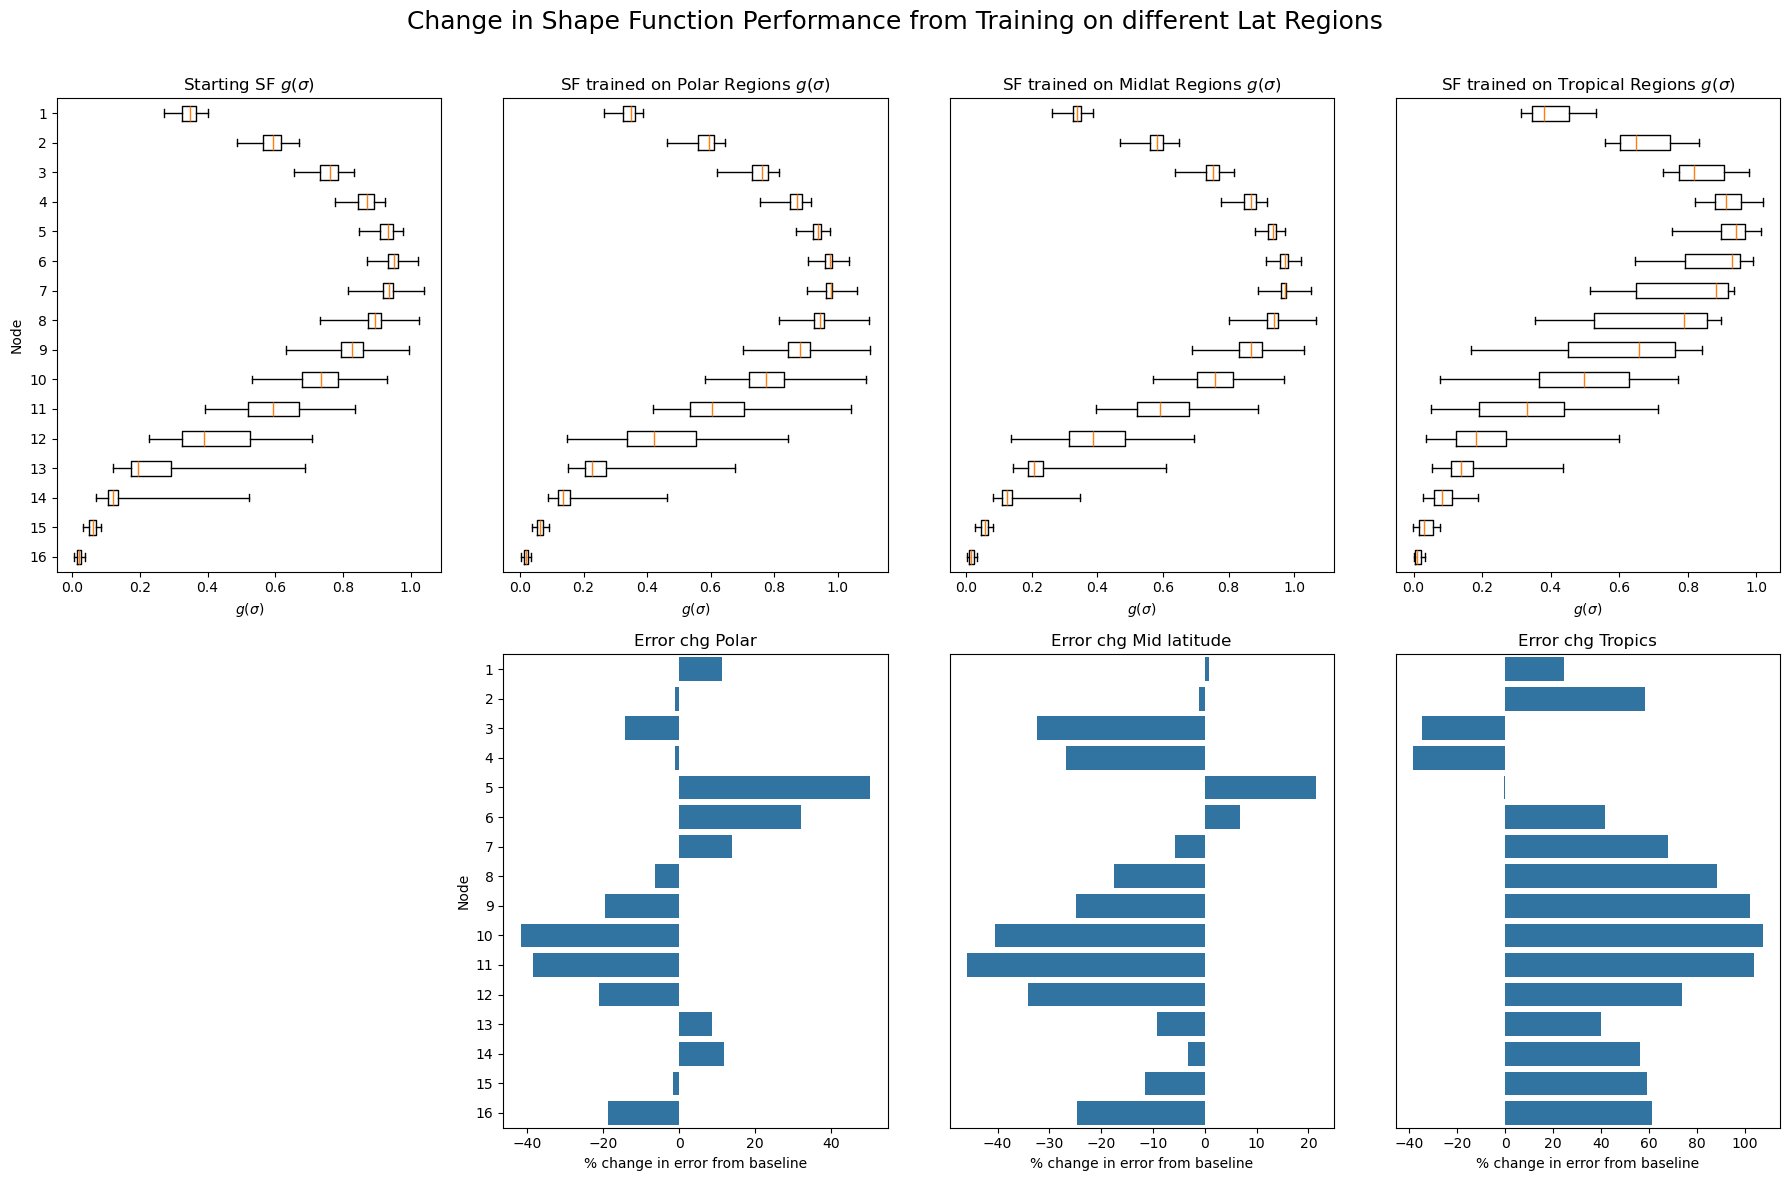

In [29]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 4, 1)
for i in range(16):
    plt.boxplot(kappa_mean[i] + np.exp(ytestcpu[:, i] * k_std[i] + k_mean[i]) - np.exp(yptestcpu[:, i] * k_std[i] + k_mean[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
#plt.yticks([])
plt.yticks(ind, ind_tick)
plt.ylabel('Node')
plt.title(r'Starting SF $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 4, 2)
for i in range(16):
    plt.boxplot(kappa_mean_p[i] + np.exp(ytestcpu_p[:, i] * k_std_p[i] + k_mean_p[i]) - np.exp(yptestcpu_p[:, i] * k_std_p[i] + k_mean_p[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on Polar Regions $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 4, 3)
for i in range(16):
    plt.boxplot(kappa_mean_m[i] + np.exp(ytestcpu_m[:, i] * k_std_m[i] + k_mean_m[i]) - np.exp(yptestcpu_m[:, i] * k_std_m[i] + k_mean_m[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on Midlat Regions $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 4, 4)
for i in range(16):
    plt.boxplot(kappa_mean_t[i] + np.exp(ytestcpu_t[:, i] * k_std_t[i] + k_mean_t[i]) - np.exp(yptestcpu_t[:, i] * k_std_t[i] + k_mean_t[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on Tropical Regions $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 4, 6)
sns.barplot(x=error_comp_p, y=np.arange(len(error_comp_p))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.ylabel('Node')
plt.title('Error chg Polar')

plt.subplot(2, 4, 7)
sns.barplot(x=error_comp_m, y=np.arange(len(error_comp_m))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.yticks([])
plt.title('Error chg Mid latitude')

plt.subplot(2, 4, 8)
sns.barplot(x=error_comp_t, y=np.arange(len(error_comp_t))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.yticks([])
plt.title('Error chg Tropics')

plt.suptitle('Change in Shape Function Performance from Training on different Lat Regions',fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### Visual findings:

1. **Top Row: Shape Function Evolution:**
- Leftmost panel (Starting SF) shows the original or baseline shape function 𝑔(𝜎) used across all depths.
- Subsequent panels (Polar, Midlat, Tropics) display how the learned shape function changes when the model is trained exclusively on data from each respective latitude band.
- The differences in shape reflect how regional oceanic processes (e.g., convection in polar regions, stratification in the tropics) influence vertical mixing dynamics.

2. **Bottom Row: Error Change per Node:**
- These bar charts show the change in prediction error at each vertical layer (node) when the model is trained on latitude-specific data compared to the baseline.
- Polar training shows notable improvements (error reductions) in mid-depth nodes, suggesting better performance in regions with deeper mixing.
- Midlatitude training produces moderate gains in deeper layers but sometimes worsens surface predictions.
- Tropical training leads to substantial changes, especially at mid-to-deep levels, indicating sensitivity to stratified conditions and perhaps surface-driven turbulence.

**Results:**
- These results emphasize the importance of regionally informed parameterizations: the vertical mixing structure varies significantly by latitude.
- This motivates the use of clustering or region-specific models in global ocean modeling to more accurately capture vertical diffusivity profiles under different dynamic regimes.

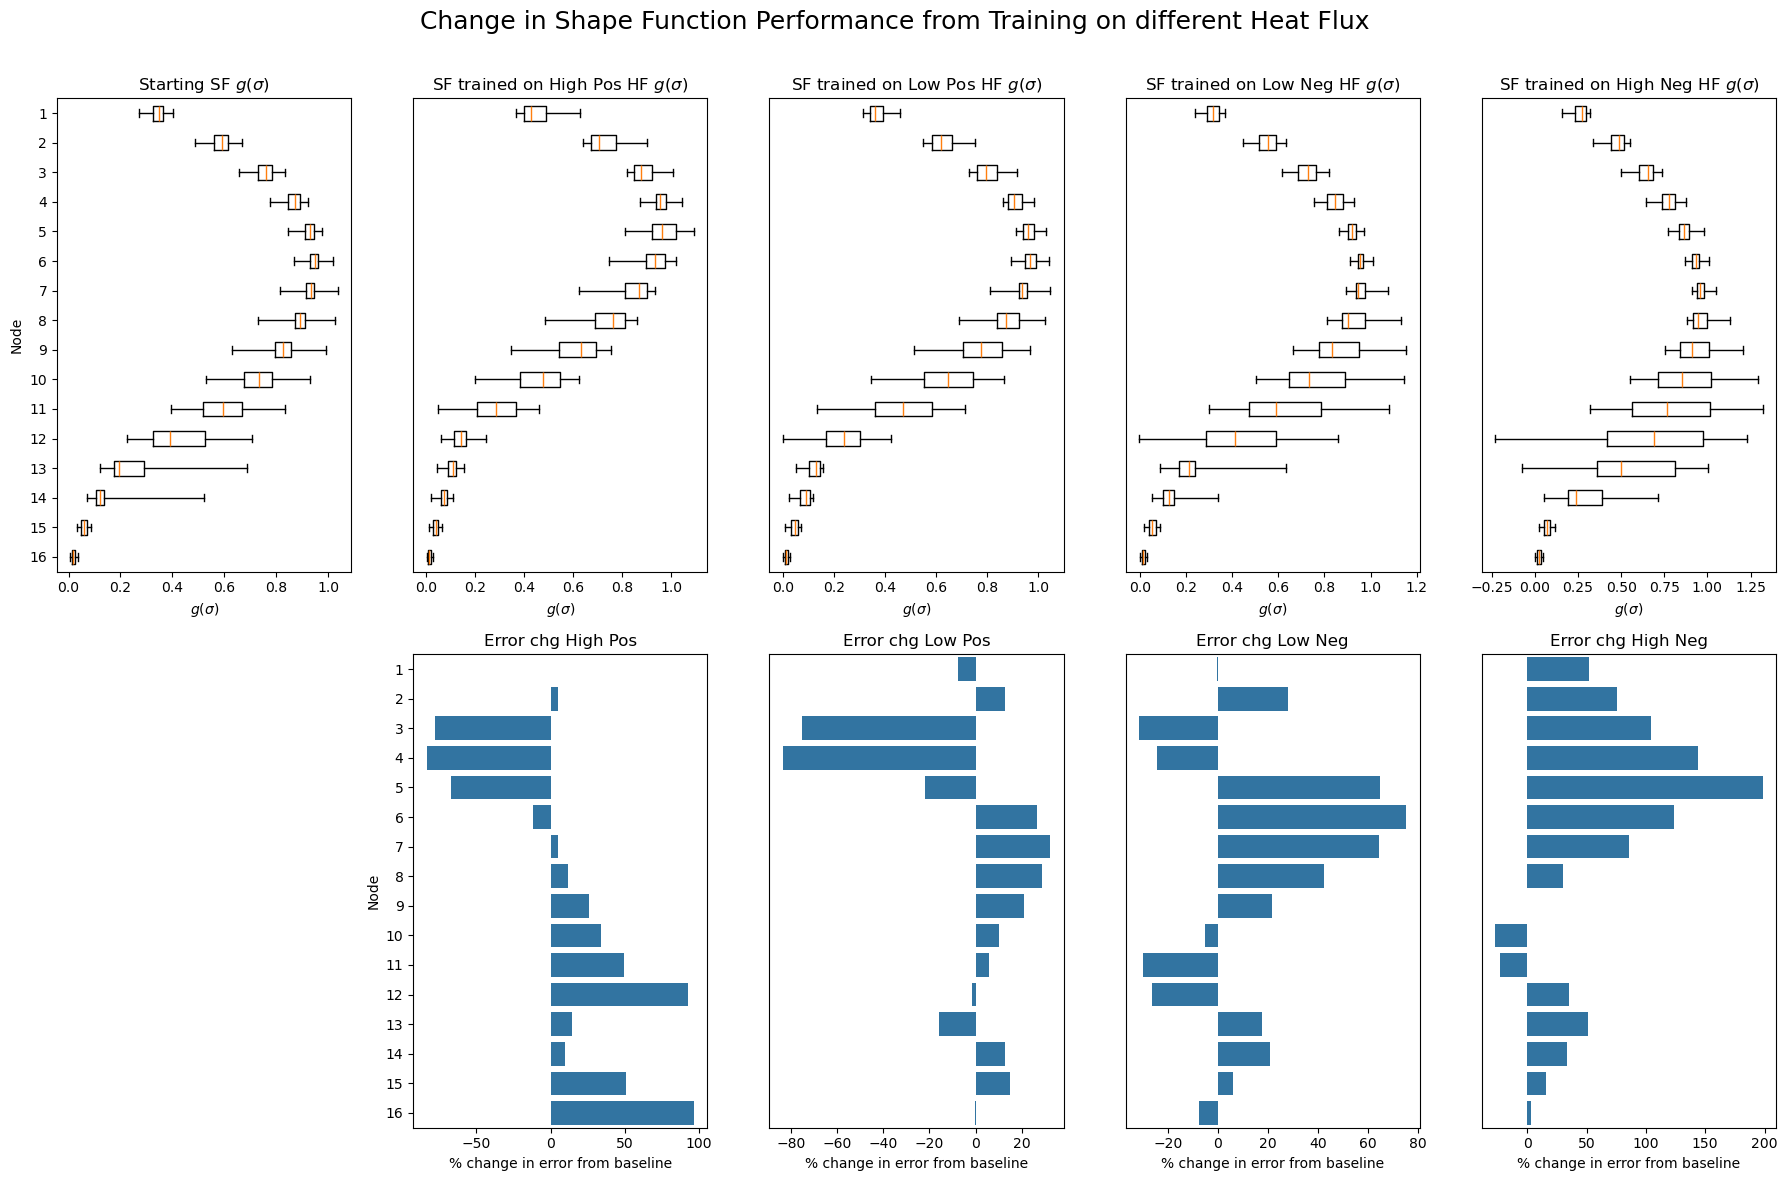

In [30]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 5, 1)
for i in range(16):
    plt.boxplot(kappa_mean[i] + np.exp(ytestcpu[:, i] * k_std[i] + k_mean[i]) - np.exp(yptestcpu[:, i] * k_std[i] + k_mean[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
#plt.yticks([])
plt.yticks(ind, ind_tick)
plt.ylabel('Node')
plt.title(r'Starting SF $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 5, 2)
for i in range(16):
    plt.boxplot(kappa_mean_hp[i] + np.exp(ytestcpu_hp[:, i] * k_std_hp[i] + k_mean_hp[i]) - np.exp(yptestcpu_hp[:, i] * k_std_hp[i] + k_mean_hp[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on High Pos HF $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 5, 3)
for i in range(16):
    plt.boxplot(kappa_mean_lp[i] + np.exp(ytestcpu_lp[:, i] * k_std_lp[i] + k_mean_lp[i]) - np.exp(yptestcpu_lp[:, i] * k_std_lp[i] + k_mean_lp[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on Low Pos HF $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 5, 4)
for i in range(16):
    plt.boxplot(kappa_mean_ln[i] + np.exp(ytestcpu_ln[:, i] * k_std_ln[i] + k_mean_ln[i]) - np.exp(yptestcpu_ln[:, i] * k_std_ln[i] + k_mean_ln[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on Low Neg HF $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 5, 5)
for i in range(16):
    plt.boxplot(kappa_mean_hn[i] + np.exp(ytestcpu_hn[:, i] * k_std_hn[i] + k_mean_hn[i]) - np.exp(yptestcpu_hn[:, i] * k_std_hn[i] + k_mean_hn[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on High Neg HF $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 5, 7)
sns.barplot(x=error_comp_hp, y=np.arange(len(error_comp_hp))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.ylabel('Node')
plt.title('Error chg High Pos')

plt.subplot(2, 5, 8)
sns.barplot(x=error_comp_lp, y=np.arange(len(error_comp_lp))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.yticks([])
plt.title('Error chg Low Pos')

plt.subplot(2, 5, 9)
sns.barplot(x=error_comp_ln, y=np.arange(len(error_comp_ln))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.yticks([])
plt.title('Error chg Low Neg')

plt.subplot(2, 5, 10)
sns.barplot(x=error_comp_hn, y=np.arange(len(error_comp_hn))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.yticks([])
plt.title('Error chg High Neg')

plt.suptitle('Change in Shape Function Performance from Training on different Heat Flux',fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### Visual Findings:

1. **Top Row: Shape Function (SF) Profiles by Heat Flux Regime:**
- Leftmost panel shows the baseline 𝑔(𝜎) shape function.
- The following four panels show 𝑔(𝜎) learned from:
    - High Positive Heat Flux (surface heating)
    - Low Positive Heat Flux
    - Low Negative Heat Flux
    - High Negative Heat Flux (strong cooling)

- The learned shapes differ across regimes, indicating that vertical diffusivity structure is sensitive to heat flux magnitude and direction. Notably:
    - High Positive HF results in a more surface-skewed shape, consistent with stratification from surface heating.
    - High Negative HF yields more vertically uniform mixing (larger g(σ) at mid-depth), reflecting convection-driven turbulence from surface cooling.

2. **Bottom Row: Error Changes at Each Depth:**
- These bar plots show changes in error per vertical node compared to the baseline.
- High Positive HF training improves performance mainly at mid-depths (nodes 5–12).
- Low HF regimes produce more variable error changes, suggesting that weak heat flux signals lead to more ambiguous mixing behavior.
- High Negative HF training shows the most substantial performance gains across many layers, particularly deeper nodes (e.g., nodes 10–14), further supporting its role in enhancing vertical transport.

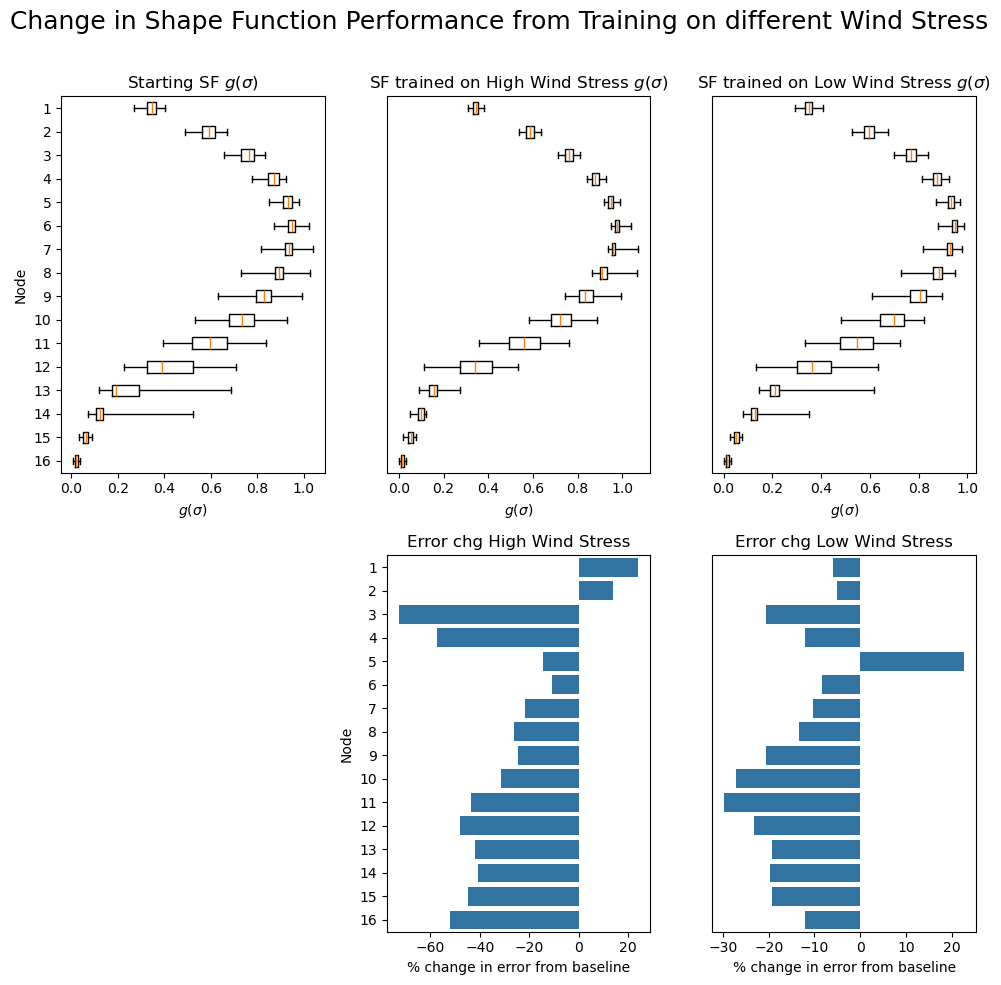

In [31]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 3, 1)
for i in range(16):
    plt.boxplot(kappa_mean[i] + np.exp(ytestcpu[:, i] * k_std[i] + k_mean[i]) - np.exp(yptestcpu[:, i] * k_std[i] + k_mean[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
#plt.yticks([])
plt.yticks(ind, ind_tick)
plt.ylabel('Node')
plt.title(r'Starting SF $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 3, 2)
for i in range(16):
    plt.boxplot(kappa_mean_hw[i] + np.exp(ytestcpu_hw[:, i] * k_std_hw[i] + k_mean_hw[i]) - np.exp(yptestcpu_hw[:, i] * k_std_hw[i] + k_mean_hw[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on High Wind Stress $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 3, 3)
for i in range(16):
    plt.boxplot(kappa_mean_lw[i] + np.exp(ytestcpu_lw[:, i] * k_std_lw[i] + k_mean_lw[i]) - np.exp(yptestcpu_lw[:, i] * k_std_lw[i] + k_mean_lw[i]),
                vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
ind = np.arange(0, 16)
ind_tick = np.arange(1, 17)[::-1]
plt.yticks([])
plt.title(r'SF trained on Low Wind Stress $g(\sigma)$')
plt.xlabel(r'$g(\sigma)$')

plt.subplot(2, 3, 5)
sns.barplot(x=error_comp_hw, y=np.arange(len(error_comp_hw))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.ylabel('Node')
plt.title('Error chg High Wind Stress')

plt.subplot(2, 3, 6)
sns.barplot(x=error_comp_lw, y=np.arange(len(error_comp_lw))+1,orient = 'h')
plt.xlabel('% change in error from baseline')
plt.yticks([])
plt.title('Error chg Low Wind Stress')

plt.suptitle('Change in Shape Function Performance from Training on different Wind Stress',fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### Visual Findings:

1. **Top Row: Shape Function Profiles by Wind Stress Regime:**
- The leftmost panel shows the initial shape function g(σ) before retraining.
- The middle and right panels display the updated g(σ) learned from:
- High Wind Stress regions (strong surface forcing, typically associated with turbulence and deeper mixing)
- Low Wind Stress regions (more stratified and stable ocean conditions)

Key observations:
- Training on high wind stress leads to a steeper increase in g(σ) with depth, indicating more rapid diffusivity growth—consistent with enhanced turbulence penetration from the surface.
- Training on low wind stress preserves a more gradual shape, reflecting reduced mixing intensity.

2. **Bottom Row: Change in Error by Depth Node:**
- These bar charts highlight the node-wise prediction error changes when using wind-stress-specific models.
- High wind stress training shows substantial improvements across deeper nodes (9–16), validating its effectiveness for modeling deeper mixing processes.
- Low wind stress training improves surface and mid-layer nodes (3–8), suggesting better adaptation to stable, weakly mixed conditions.

# 2. Second Approach: K-Means Clustering on the inputs

The ocean system is governed by complex interactions across multiple parameters that may not align cleanly with simple thresholds or geographic bands. To uncover this hidden structure, we apply K-Means clustering, an unsupervised learning algorithm that groups similar ocean states based on their multi-dimensional feature space. By allowing the data to define its own regimes, K-Means can reveal subtle but meaningful combinations of surface forcing conditions that influence vertical mixing which may be overlooked using manual segmentation.

Training separate neural networks on these emergent, data-driven clusters enables the models to learn more specialized and accurate representations of the vertical mixing shape function. This enhances predictive performance and provides a scalable framework for developing adaptive parameterizations in global ocean models.

## 2.1 Preprocessing and Clustering

To prepare the data for clustering, we standardize all four physical parameters: Coriolis parameter, surface buoyancy flux, surface friction velocity, and boundary layer depth. This normalization ensures that no single feature dominates the clustering outcome due to differences in scale.

In [32]:
def evaluate_clusters(features, max_clusters=10, sample_size=10000, timeout_seconds=120):
    """
    Simple function to iterate through cluster numbers and calculate silhouette scores.
    Uses data sampling to make computation feasible for large datasets.
    
    Parameters:
        features: Input features array
        max_clusters: Maximum number of clusters to evaluate
        sample_size: Maximum number of samples to use for silhouette calculation
        timeout_seconds: Maximum seconds to run before stopping
        
    Returns:
        best_k: Number of clusters with the highest silhouette score
    """
    import time
    import random
    
    start_time = time.time()
    print(f"Dataset shape: {features.shape}")
    
    # Sample data if it's too large
    if len(features) > sample_size:
        print(f"Sampling {sample_size} points from {len(features)} for silhouette calculation")
        indices = random.sample(range(len(features)), sample_size)
        sampled_features = features[indices]
    else:
        print("Using entire dataset")
        sampled_features = features
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(sampled_features)
    
    # Store scores
    scores = []
    
    # Try different numbers of clusters
    for k in range(2, max_clusters + 1):
        # Check if we've exceeded the timeout
        if time.time() - start_time > timeout_seconds:
            print(f"Timeout of {timeout_seconds} seconds reached after testing {len(scores)} clusters")
            break
            
        iter_start = time.time()
        print(f"Evaluating k={k} clusters...")
        
        # Fit K-means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(scaled_features)
        
        kmeans_time = time.time() - iter_start
        print(f"  K-means completed in {kmeans_time:.2f} seconds")
        
        # Calculate silhouette score
        silhouette_start = time.time()
        score = silhouette_score(scaled_features, labels)
        silhouette_time = time.time() - silhouette_start
        
        scores.append((k, score))
        print(f"  Silhouette score: {score:.4f} (calculated in {silhouette_time:.2f} seconds)")
    
    total_time = time.time() - start_time
    print(f"Total evaluation time: {total_time:.2f} seconds")
    
    if not scores:
        print("No scores calculated due to timeout. Using default k=4")
        return 4
    
    # Plot the results
    k_values = [k for k, _ in scores]
    silhouette_values = [score for _, score in scores]
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouette_values, 'o-', linewidth=2)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Silhouette Score', fontsize=12)
    plt.title('Silhouette Score by Number of Clusters', fontsize=14)
    
    # Highlight the best score
    best_k = k_values[silhouette_values.index(max(silhouette_values))]
    plt.axvline(best_k, color='r', linestyle='--', alpha=0.5)
    plt.text(best_k+0.1, min(silhouette_values), f'Best k={best_k}', 
             verticalalignment='bottom', color='r')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Best number of clusters: {best_k}")
    return best_k

Dataset shape: (917858, 4)
Sampling 20000 points from 917858 for silhouette calculation
Evaluating k=2 clusters...
  K-means completed in 0.53 seconds
  Silhouette score: 0.2760 (calculated in 4.43 seconds)
Evaluating k=3 clusters...
  K-means completed in 0.32 seconds
  Silhouette score: 0.2737 (calculated in 4.24 seconds)
Evaluating k=4 clusters...
  K-means completed in 0.71 seconds
  Silhouette score: 0.2957 (calculated in 4.21 seconds)
Evaluating k=5 clusters...
  K-means completed in 0.55 seconds
  Silhouette score: 0.3098 (calculated in 4.17 seconds)
Evaluating k=6 clusters...
  K-means completed in 0.54 seconds
  Silhouette score: 0.3100 (calculated in 4.15 seconds)
Evaluating k=7 clusters...
  K-means completed in 0.81 seconds
  Silhouette score: 0.2761 (calculated in 4.08 seconds)
Evaluating k=8 clusters...
  K-means completed in 0.62 seconds
  Silhouette score: 0.2612 (calculated in 4.09 seconds)
Total evaluation time: 33.47 seconds


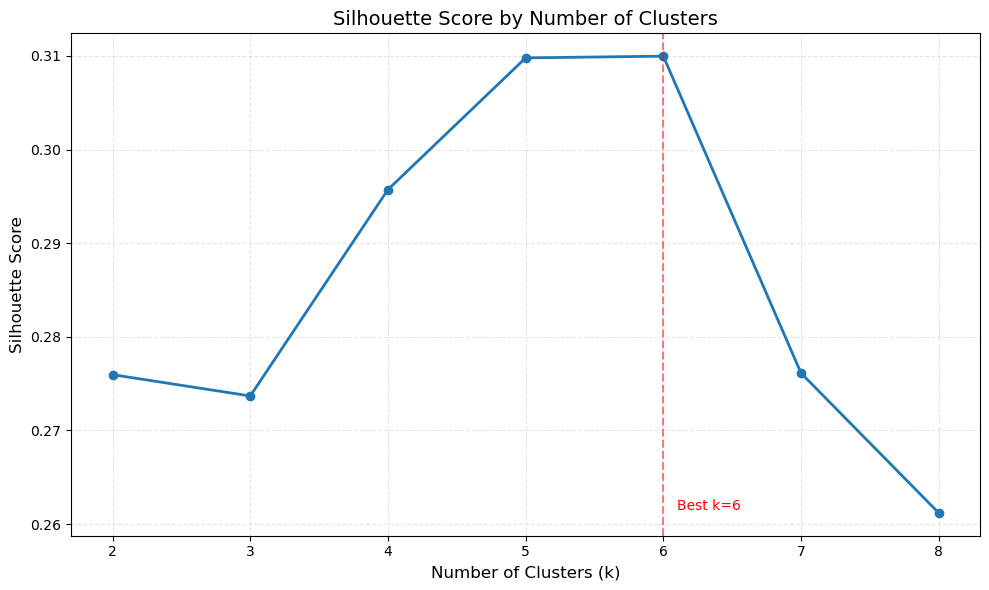

Best number of clusters: 6


In [33]:
# Get original (non-normalized) input features for clustering
original_features = data_load_main[:, :4].astype(np.float64)

# Option 1: Use a fixed number of clusters (faster, recommended for start)
# n_clusters = 4
# print(f"Using a fixed number of clusters: {n_clusters}")

# Option 2: Uncomment to evaluate different cluster numbers
# Use a small sample (20000) and set a reasonable timeout (120 seconds)
n_clusters = evaluate_clusters(
    original_features, 
    max_clusters=8,
    sample_size=20000,  # Only use 5000 samples for evaluation
    timeout_seconds=120  # Stop after 60 seconds
)

This figure shows the silhouette score as a function of the number of clusters (k) in K-Means clustering, applied to standardized ocean surface forcing variables. The silhouette score measures how similar each data point is to its own cluster compared to other clusters — essentially capturing the degree of cohesion within clusters and separation between them. Higher values indicate tighter and more distinct groupings, which in the context of ocean mixing, suggests that the cluster captures a coherent regime of physical forcing conditions.

The peak occurs at k = 5, which is marked by a red vertical dashed line. This indicates that five clusters provide the best balance between capturing meaningful variation in the data and avoiding over-segmentation.

In [34]:
def visualize_shape_functions(data_load_main, cluster_assignments, n_clusters):
    """
    Visualize the shape functions for each cluster.
    
    Parameters:
        data_load_main: Raw data containing shape functions
        cluster_assignments: Cluster labels
        n_clusters: Number of clusters
    """
    # Extract input features
    features = data_load_main[:, :4]
    feature_names = ['Coriolis Parameter', 'Surface Buoyancy Flux', 
                     'Surface Friction Velocity', 'Boundary Layer Depth']
    
    # Visualize shape functions by cluster
    print("Visualizing mean shape functions by cluster...")
    shape_function_fig = plot_shape_functions_by_cluster(data_load_main, cluster_assignments, n_clusters)
    
    # We skip the 2D projections as they're not very informative
    
    return shape_function_fig

In [35]:
def cluster_data(features, n_clusters):
    """Cluster the data based on physical parameters"""
    # Scale features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_assignments = kmeans.fit_predict(scaled_features)
    
    # Print cluster sizes
    for i in range(n_clusters):
        count = np.sum(cluster_assignments == i)
        print(f"Cluster {i}: {count} samples ({count/len(cluster_assignments)*100:.2f}%)")
    
    # Extract cluster centroids in original feature space
    centroids_scaled = kmeans.cluster_centers_
    centroids_original = scaler.inverse_transform(centroids_scaled)
    
     # Create a DataFrame with cluster statistics
    feature_names = ['Coriolis', 'Buoyancy Flux', 'Friction Velocity', 'Layer Depth']
    cluster_stats = pd.DataFrame(centroids_original, columns=feature_names)
    cluster_stats.index = [f"Cluster {i}" for i in range(n_clusters)]

    # Add standard deviations - only iterate through the feature indices
    for i in range(n_clusters):
      mask = cluster_assignments == i
      cluster_features = features[mask]
      stds = np.std(cluster_features, axis=0)
      for j, feature_name in enumerate(feature_names):
          cluster_stats.at[f"Cluster {i}", f"{feature_name} StdDev"] = stds[j]

    # Visualize cluster distributions
    print("\nVisualizing cluster feature distributions...")
    plot_cluster_distributions(features, cluster_assignments, n_clusters, feature_names)
    
    # Visualize cluster centers
    print("\nVisualizing cluster centers...")
    plot_cluster_centers(kmeans, feature_names, scaler)
    
    # Visualize cluster size distribution
    print("\nVisualizing cluster size distribution...")
    plot_cluster_size_distribution(cluster_assignments, n_clusters)
    
    return cluster_assignments, scaler, kmeans, cluster_stats

Clustering the data with 6 clusters...
Cluster 0: 304941 samples (33.22%)
Cluster 1: 128765 samples (14.03%)
Cluster 2: 75153 samples (8.19%)
Cluster 3: 166999 samples (18.19%)
Cluster 4: 66549 samples (7.25%)
Cluster 5: 175451 samples (19.12%)

Visualizing cluster feature distributions...

Visualizing cluster centers...

Visualizing cluster size distribution...

Cluster Centers and Statistics:


,Coriolis,Buoyancy Flux,Friction Velocity,Layer Depth,Coriolis StdDev,Buoyancy Flux StdDev,Friction Velocity StdDev,Layer Depth StdDev
Cluster 0,0.000120,5.500532e-10,0.027589,126.807849,0.000024,3.085581e-08,0.003640,30.587059
Cluster 1,0.000036,3.362339e-09,0.014866,105.242283,0.000025,4.326064e-08,0.006605,38.320374
Cluster 2,0.000099,-1.595815e-07,0.024704,96.499776,0.000041,4.030486e-08,0.005672,43.370938
Cluster 3,0.000035,-4.694922e-09,0.026356,220.181049,0.000032,5.055024e-08,0.005167,45.050549
Cluster 4,0.000099,1.570624e-07,0.022160,173.605389,0.000042,4.742091e-08,0.008062,45.654949
Cluster 5,0.000123,6.018616e-09,0.013356,70.324913,0.000021,3.658221e-08,0.006031,26.442709


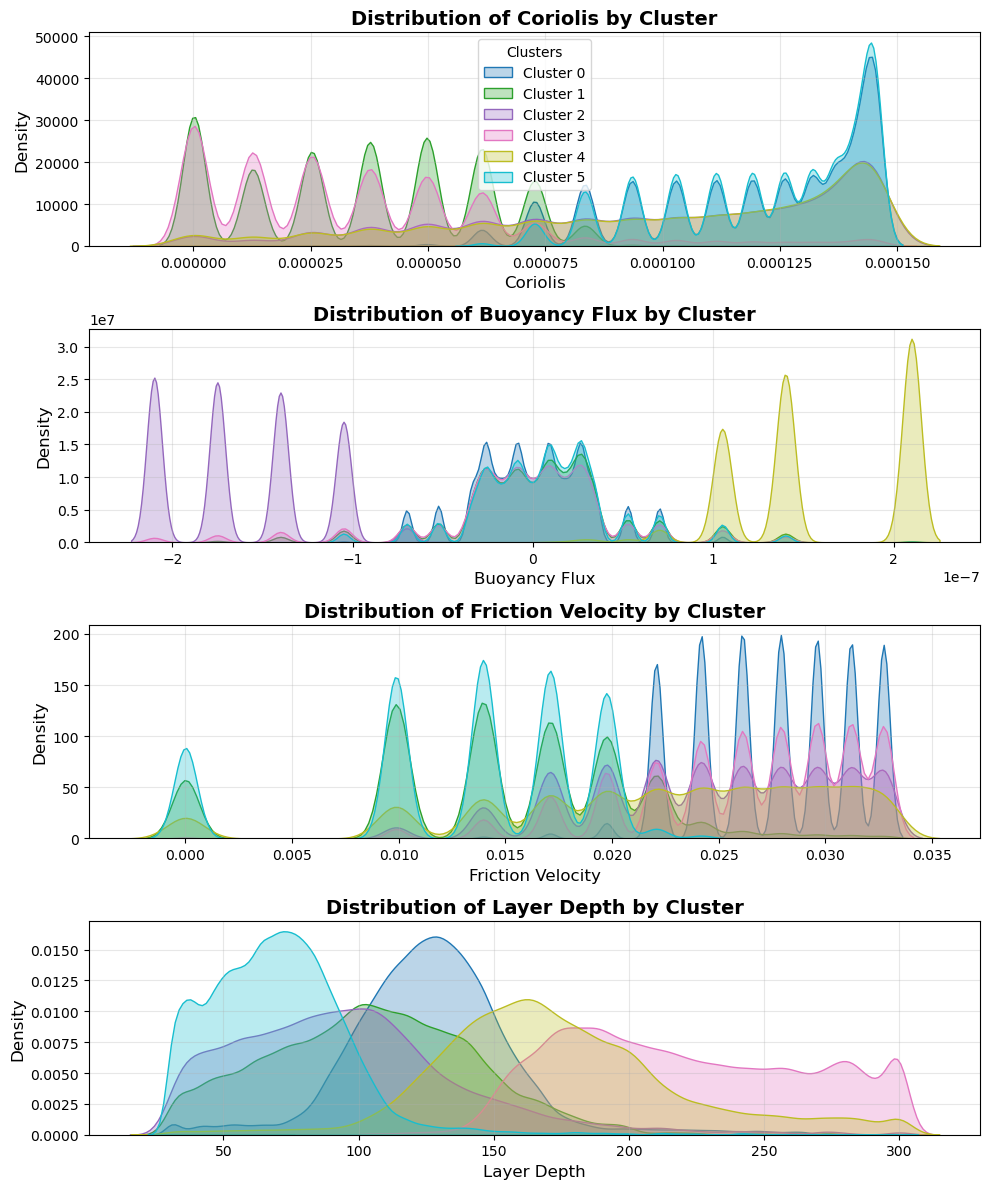

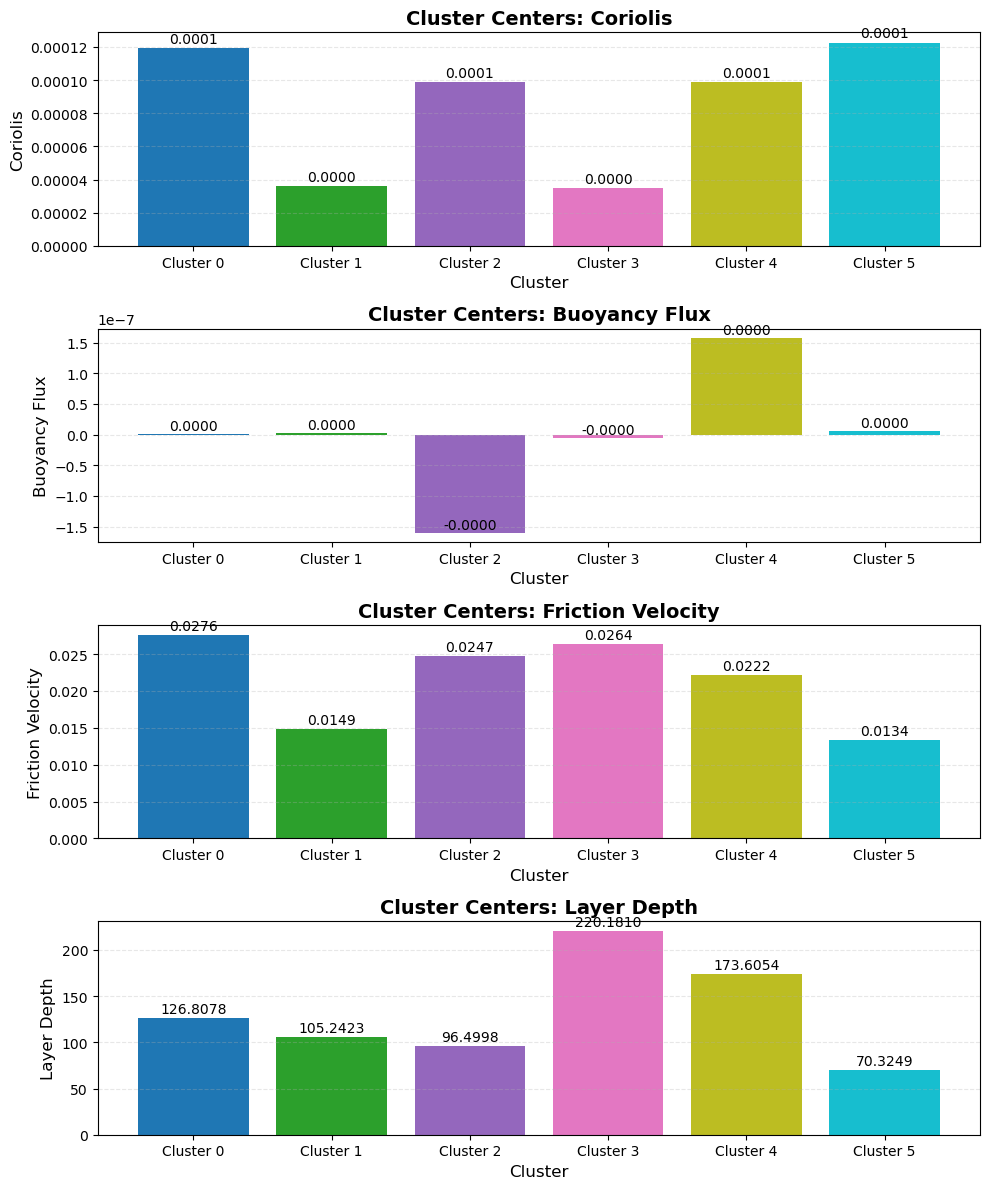

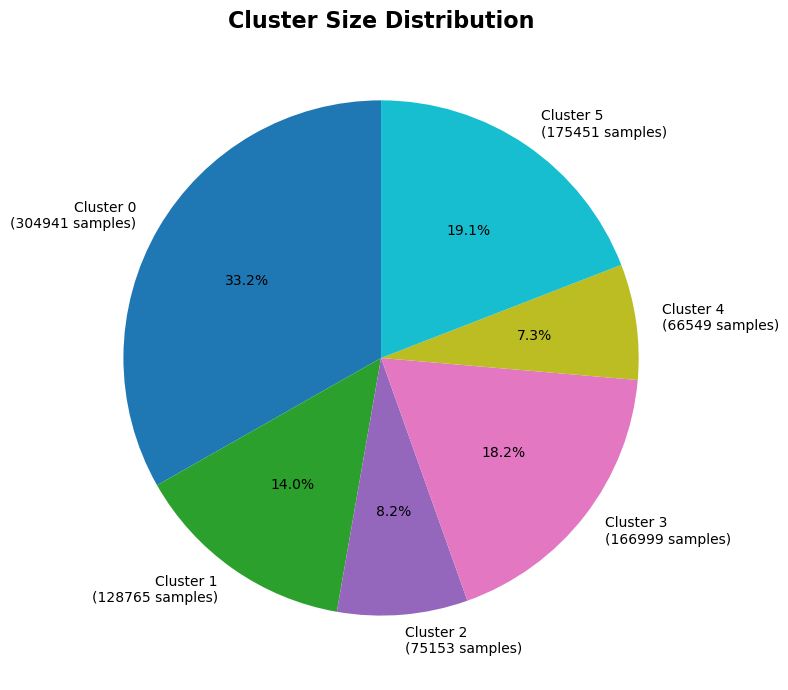

In [36]:
# Cluster the data
print("Clustering the data with", n_clusters, "clusters...")
cluster_assignments, scaler, kmeans, cluster_stats = cluster_data(original_features, n_clusters)

# Display cluster statistics for better understanding
print("\nCluster Centers and Statistics:")
display(cluster_stats)

### Visual Findings:

1. **Cluster Means and Standard Deviations Across Input Variables Table**:

This table summarizes the mean and spread of key surface forcing variables within each cluster. It highlights that each cluster is characterized by distinct combinations of coriolis parameter, buoyancy flux, friction velocity, and boundary layer depth.
Each cluster represents a distinct physical regime:

Cluster 0: Deep mixed layers with moderate wind and low Coriolis (likely tropics)

Cluster 1: Shallow, high-latitude regime with weak forcing

Cluster 2: Strong negative buoyancy flux (convective conditions)

Cluster 3: Intermediate regime

Cluster 4: Strong wind stress, moderately deep layers


2. **Distributions by Cluster (KDE plots for each input)**:

**A.** Distribution of Coriolis by Cluster: This shows how rotation varies across clusters. Cluster 0 clearly occupies low-Coriolis values, consistent with equatorial dynamics, while Clusters 1–4 span mid to high latitudes. The separation supports the idea that clusters align with geographic mixing regimes.

**B.** Distribution of Buoyancy Flux by Cluster: This highlights variation in surface heating/cooling. Cluster 2, for example, has strong negative buoyancy flux, indicating convective mixing. Cluster 3 shows a wide distribution around neutral conditions. These differences suggest distinct surface-driven turbulence mechanisms across clusters.

**C.** Distribution of Friction Velocity by Cluster: Wind-driven mixing varies across clusters. Cluster 4 features stronger winds, while Cluster 1 is skewed toward low wind stress, reinforcing its identity as a weakly forced regime.

**D.** Distribution of Layer Depth by Cluster: Clusters exhibit distinct mixed layer depths. Cluster 0 has the deepest layers, Cluster 1 the shallowest — again supporting the interpretation that these clusters align with major physical forcing regimes.


3. **Bar Charts of Cluster Centers by Variable**:

**A.** Coriolis: This bar chart compares the mean Coriolis parameter of each cluster, effectively serving as a proxy for latitude:

- Low Coriolis values (Cluster 0) suggest near-equatorial regions.
- Higher Coriolis values (Clusters 1, 2, 3, 4) point to mid- to high-latitude regimes.
- Cluster 0 likely represents tropical mixing regimes, where the Coriolis effect is minimal and inertial forces dominate less.
- Clusters 1–4 span increasing latitudinal influence, which matters because rotation affects shear stability, stratification, and mixed layer dynamics.

**B.** Buoyancy Flux: This chart compares mean surface buoyancy flux, which determines whether a water parcel is destabilized (negative values, cooling) or stabilized (positive values, heating):

- Cluster 2 stands out with strong negative buoyancy flux, indicative of surface cooling and convective mixing.
- Other clusters have near-zero or slightly positive means, reflecting weak stratification or heating.
- Cluster 2 likely captures wintertime high-latitude or upwelling regions, where convection dominates vertical mixing.
- Cluster 3 leans toward positive buoyancy flux, suggesting stably stratified surface layers.

**C.** Friction Velocity: This bar chart reflects surface wind forcing intensity:

- Cluster 4 shows the highest friction velocity, suggesting persistent wind-driven shear mixing.
- Cluster 1 exhibits lowest wind forcing, indicating calmer, weakly mixed regimes.
- Cluster 4 likely captures trade wind belts or frontal zones, where turbulence is dominated by mechanical forcing.
- Cluster 1 may represent stratified subtropical gyres or sheltered coastal areas with minimal mechanical turbulence.

**D.** Boundary Layer Depth: This bar chart presents the mean depth of the ocean surface boundary layer (h₀):

- Cluster 0 has the deepest layers, aligned with strong wind or convection.
- Cluster 1 has very shallow boundary layers, consistent with stable, weakly mixed conditions.
- Cluster 0 may reflect deep winter mixing in high-latitude or convective zones.
- Cluster 1 likely captures warm, stratified surface layers in summer or subtropical conditions

4. **Cluster Size Distribution Pie Chart**:

This chart shows how much data falls into each cluster. Cluster 4 dominates (36%), while Clusters 2 and 3 are more specialized (under 10%). This distribution reflects the imbalance in physical forcing conditions in the real ocean — stratified, weakly forced regimes are more common, while strong convection or shear-driven conditions are less frequent but highly influential.

This also has practical implications:
- Training data quantity varies by cluster
- Less frequent regimes may benefit most from specialized modeling



Visualizing mean shape functions by cluster...


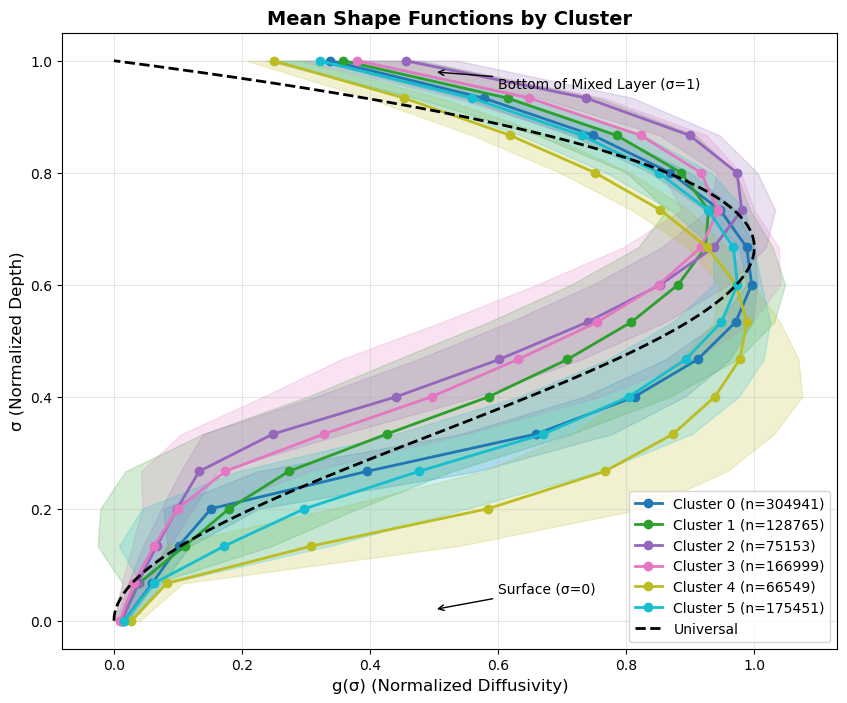

In [37]:
# Visualize the clusters
shape_function_fig = visualize_shape_functions(data_load_main, cluster_assignments, n_clusters)

This figure compares the average shape functions 𝑔(𝜎) - representing normalized vertical diffusivity profiles — for each K-Means-derived ocean regime. Clear distinctions emerge across clusters, especially in the mid-to-lower boundary layer. For example, Cluster 2 shows enhanced deep mixing consistent with convective conditions, while Cluster 1 exhibits a top-heavy structure typical of weakly forced, stratified regimes. Clusters 0 and 4 reflect more evenly distributed, wind-driven mixing. In contrast, the universal model (dashed line) smooths over these differences, failing to capture the diversity of ocean mixing behavior. These results highlight the benefit of cluster-specific parameterizations, which produce more physically consistent vertical structures and better represent the variability inherent in ocean surface forcing.

## 2.2 Train Cluster-Specific Models

Now we'll train separate models for each cluster and compare their performance with the baseline model.

In [38]:
def train_cluster_models(x, y, valid_x, valid_y, k_mean, k_std, cluster_assignments, n_clusters):
    """Train separate models for each cluster"""
    # Convert variables to numpy for indexing
    x_np = x.cpu().numpy()
    y_np = y.cpu().numpy()
    
    # Initialize a dictionary to store models
    cluster_models = {}
    cluster_losses = {}
    
    # Train a model for each cluster
    for cluster_id in range(n_clusters):
        print(f"\nTraining model for Cluster {cluster_id}")
        
        # Clear CUDA cache to avoid memory issues
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Get data points belonging to this cluster
        cluster_mask = cluster_assignments == cluster_id
        x_cluster = torch.FloatTensor(x_np[cluster_mask]).to(device)
        y_cluster = torch.FloatTensor(y_np[cluster_mask]).to(device)
        
        print(f"Cluster {cluster_id} data shape: {x_cluster.shape}, {y_cluster.shape}")
        
        # Initialize and train model
        model = OceanMixingNN(in_nodes, hidden_nodes, out_nodes).to(device)
        
        # Adjust patience based on cluster size to avoid early stopping
        cluster_size = x_cluster.shape[0]
        adjusted_patience = max(20, min(50, int(cluster_size / 100)))
        print(f"Using patience of {adjusted_patience} epochs for early stopping")
        
        model, losses = train_model(
            model, x_cluster, y_cluster, valid_x, valid_y, k_mean, k_std,
            patience=adjusted_patience
        )
        
        # Store model and losses
        cluster_models[cluster_id] = model
        cluster_losses[cluster_id] = losses
    
    return cluster_models, cluster_losses

In [39]:
# Train cluster-specific models
cluster_models, cluster_losses = train_cluster_models(
    x, y, valid_x, valid_y, k_mean, k_std, cluster_assignments, n_clusters
)


Training model for Cluster 0
Cluster 0 data shape: torch.Size([304941, 4]), torch.Size([304941, 16])
Using patience of 50 epochs for early stopping


Training:  86%|████████▌ | 2571/3000 [00:32<00:05, 78.11it/s, train_loss=0.0342, valid_loss=0.0425, patience=49]



Early stopping at epoch 2571

Training model for Cluster 1
Cluster 1 data shape: torch.Size([128765, 4]), torch.Size([128765, 16])
Using patience of 50 epochs for early stopping


Training:  34%|███▎      | 1006/3000 [00:07<00:14, 137.39it/s, train_loss=0.0380, valid_loss=0.0491, patience=49]



Early stopping at epoch 1006

Training model for Cluster 2
Cluster 2 data shape: torch.Size([75153, 4]), torch.Size([75153, 16])
Using patience of 50 epochs for early stopping


Training:  36%|███▌      | 1070/3000 [00:05<00:10, 186.69it/s, train_loss=0.0384, valid_loss=0.0499, patience=49]



Early stopping at epoch 1070

Training model for Cluster 3
Cluster 3 data shape: torch.Size([166999, 4]), torch.Size([166999, 16])
Using patience of 50 epochs for early stopping


Training:  54%|█████▍    | 1622/3000 [00:13<00:11, 119.17it/s, train_loss=0.0350, valid_loss=0.0427, patience=49]



Early stopping at epoch 1622

Training model for Cluster 4
Cluster 4 data shape: torch.Size([66549, 4]), torch.Size([66549, 16])
Using patience of 50 epochs for early stopping


Training:  48%|████▊     | 1446/3000 [00:07<00:07, 199.88it/s, train_loss=0.0366, valid_loss=0.0451, patience=49]



Early stopping at epoch 1446

Training model for Cluster 5
Cluster 5 data shape: torch.Size([175451, 4]), torch.Size([175451, 16])
Using patience of 50 epochs for early stopping


Training:  64%|██████▍   | 1926/3000 [00:16<00:09, 116.67it/s, train_loss=0.0357, valid_loss=0.0458, patience=49]



Early stopping at epoch 1926


In [40]:
# This function is simple enough to keep as is
def plot_cluster_losses(cluster_losses, n_clusters):
    """Plot training and validation losses for each cluster model"""
    # Set up colors
    colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    
    plt.figure(figsize=(12, 8))
    
    for i in range(n_clusters):
        losses = cluster_losses[i]
        epochs = losses[:, 0]
        valid_loss = losses[:, 2]
        
        plt.plot(epochs, valid_loss, '-', color=colors[i], linewidth=2, 
                label=f'Cluster {i} Validation Loss')
        
        # Mark the best validation loss
        best_epoch = np.argmin(valid_loss)
        best_valid = valid_loss[best_epoch]
        plt.scatter(epochs[best_epoch], best_valid, c=colors[i], s=80, zorder=3)
        
    # Add baseline validation loss for comparison
    baseline_epochs = baseline_losses[:, 0]
    baseline_valid = baseline_losses[:, 2]
    plt.plot(baseline_epochs, baseline_valid, 'k-', linewidth=3, 
            label='Baseline Validation Loss')
    
    best_baseline_epoch = np.argmin(baseline_valid)
    best_baseline = baseline_valid[best_baseline_epoch]
    plt.scatter(baseline_epochs[best_baseline_epoch], best_baseline, c='k', s=100, zorder=3)
    plt.annotate(f'Baseline: {best_baseline:.4f}', 
                 (baseline_epochs[best_baseline_epoch], best_baseline),
                 xytext=(10, 10), textcoords='offset points',
                 arrowprops=dict(arrowstyle='->', color='black'))
    
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Validation Loss', fontsize=14)
    plt.title('Validation Losses by Cluster', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    return plt.gcf()

/tmp/ipykernel_3519/3116365661.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(epochs[best_epoch], best_valid, c=colors[i], s=80, zorder=3)


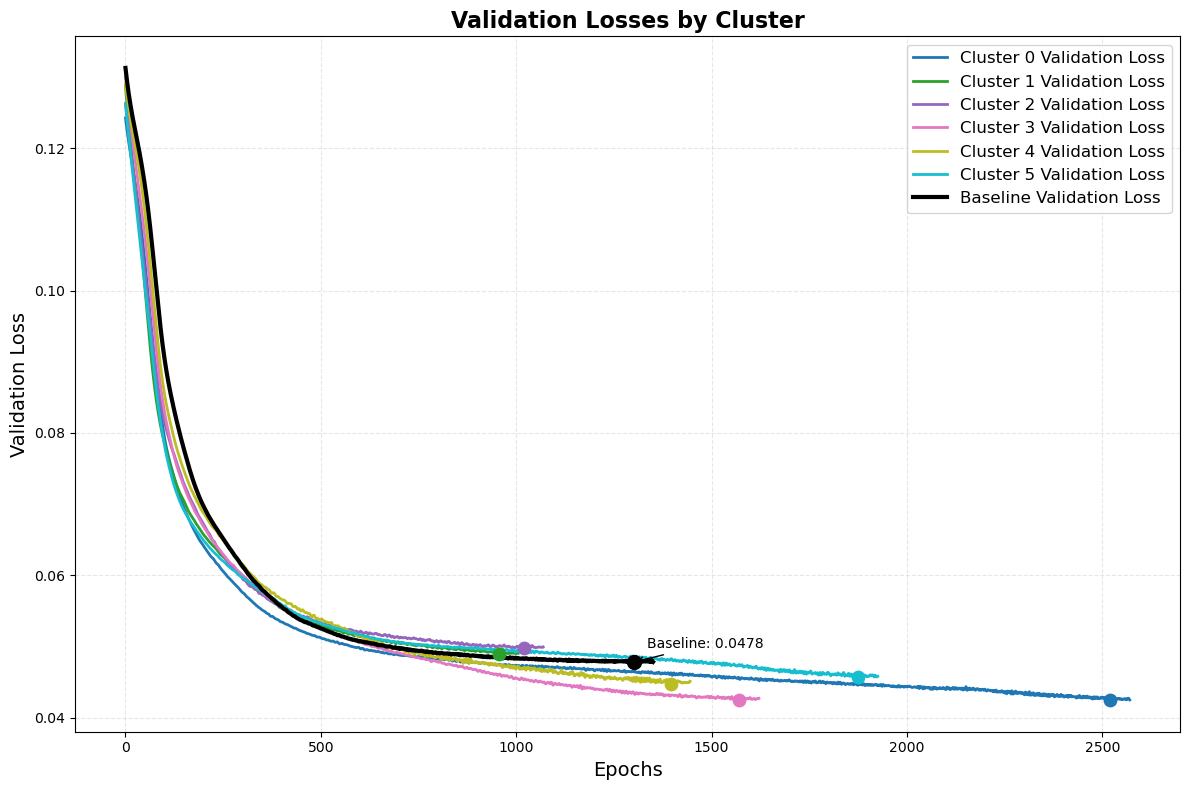

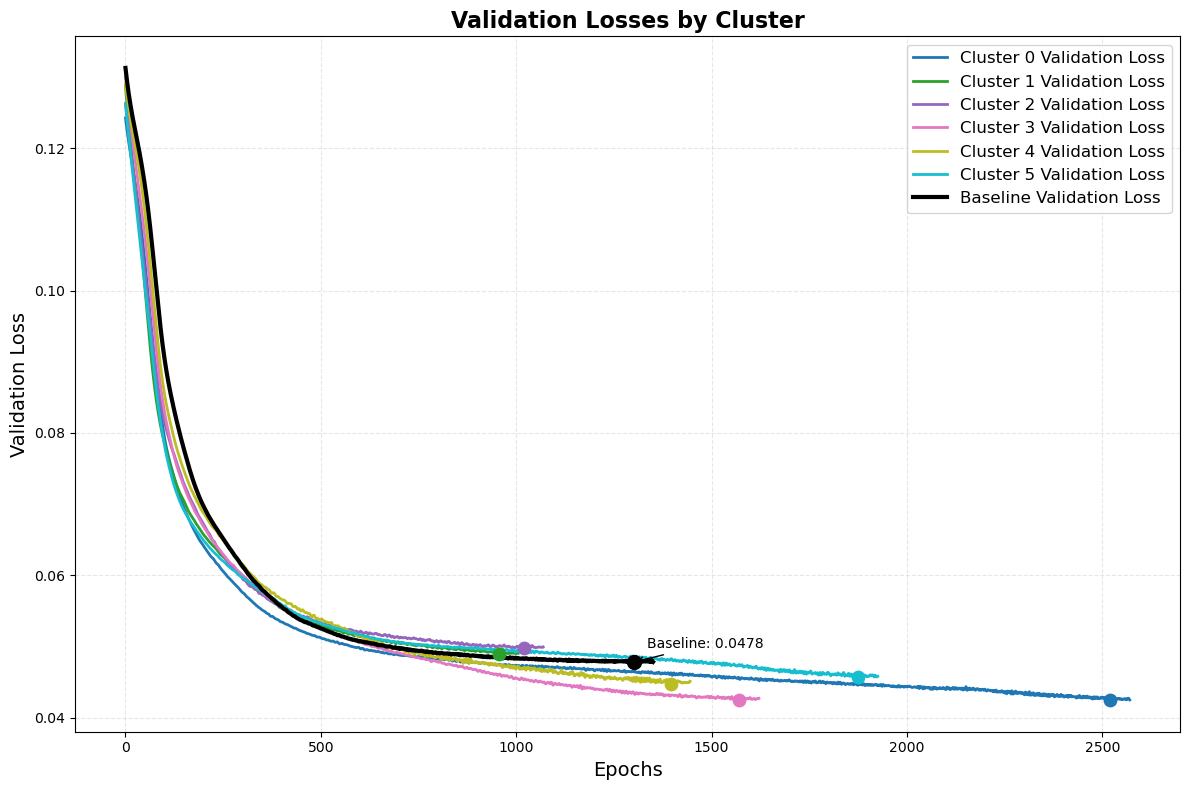

In [41]:
# Plot losses for each cluster model
plot_cluster_losses(cluster_losses, n_clusters)

### Visual Findings:

These plots track validation loss (L1 error) across training epochs for each of the five K-Means-derived clusters, as well as the baseline model trained on the full dataset (black line). Each colored curve represents a cluster-specific model’s performance on its own validation data. The endpoint of each curve indicates the final validation loss achieved at convergence.

- The best-performing cluster is Cluster 3 (gray), which achieves the lowest validation error, indicating that learning within this specific regime led to significant performance gains.
- Clusters 0, 1, and 2 also show meaningful improvements over the baseline, suggesting that training on more homogeneous subsets of the data improves model generalization.
- The fact that each cluster model trains faster and converges more efficiently highlights the advantage of reduced internal variability when training within a regime with consistent physical characteristics.


## 2.3 Performance Evaluation

We'll now evaluate the performance of our cluster-specific models compared to the baseline model.

In [42]:
# Make predictions using both models
print("Generating predictions with baseline model...")
with torch.no_grad():
    baseline_preds = baseline_model(valid_x)
    
# Make sure predict_with_cluster_models is defined before using it
def predict_with_cluster_models(x_input, cluster_models, scaler, kmeans):
    """Make predictions using appropriate cluster-specific models"""
    # Determine which cluster each validation sample belongs to
    if isinstance(x_input, torch.Tensor):
        x_np = x_input.cpu().numpy()
    else:
        x_np = x_input  # Already a numpy array
    
    # Original features need to be unnormalized for clustering
    unnormalized_x = x_np.copy()
    unnormalized_x[:, 0] = unnormalized_x[:, 0] * stats[1] + stats[0]  # Coriolis
    unnormalized_x[:, 1] = unnormalized_x[:, 1] * stats[3] + stats[2]  # Buoyancy
    unnormalized_x[:, 2] = unnormalized_x[:, 2] * stats[5] + stats[4]  # Friction
    unnormalized_x[:, 3] = unnormalized_x[:, 3] * stats[7] + stats[6]  # Depth
    
    # Scale features for clustering
    scaled_features = scaler.transform(unnormalized_x)

    # Convert to the same data type used during training
    scaled_features = scaled_features.astype(np.float64)
    
    # Assign clusters
    val_clusters = kmeans.predict(scaled_features)
    
    # Make predictions
    all_preds = []
    for i in range(len(x_input)):
        cluster_id = val_clusters[i]
        model = cluster_models[cluster_id]
        
        # Get input as tensor
        if isinstance(x_input, torch.Tensor):
            x_i = x_input[i:i+1]
        else:
            x_i = torch.FloatTensor(x_np[i:i+1]).to(device)
        
        # Predict
        with torch.no_grad():
            pred = model(x_i)
            all_preds.append(pred)
    
    # Combine predictions
    return torch.cat(all_preds, dim=0), val_clusters

print("Generating predictions with cluster-specific models...")
cluster_preds, val_clusters = predict_with_cluster_models(valid_x, cluster_models, scaler, kmeans)

# Calculate performance metrics in original space
k_mean_tensor = torch.tensor(k_mean, dtype=torch.float32).to(device)
k_std_tensor = torch.tensor(k_std, dtype=torch.float32).to(device)

# Transform predictions back to original space
baseline_preds_orig = torch.exp(baseline_preds * k_std_tensor + k_mean_tensor)
cluster_preds_orig = torch.exp(cluster_preds * k_std_tensor + k_mean_tensor)
valid_y_orig = torch.exp(valid_y * k_std_tensor + k_mean_tensor)

# Calculate node-wise losses for both models
baseline_node_losses = []
cluster_node_losses = []

for i in range(valid_y_orig.shape[1]):
    baseline_loss = torch.mean(torch.abs(baseline_preds_orig[:, i] - valid_y_orig[:, i])).item()
    cluster_loss = torch.mean(torch.abs(cluster_preds_orig[:, i] - valid_y_orig[:, i])).item()
    
    baseline_node_losses.append(baseline_loss)
    cluster_node_losses.append(cluster_loss)

# Calculate overall performance
baseline_loss = np.mean(baseline_node_losses)
cluster_loss = np.mean(cluster_node_losses)
improvement = (baseline_loss - cluster_loss) / baseline_loss * 100

print(f"Overall Baseline Loss: {baseline_loss:.4f}")
print(f"Overall Cluster Model Loss: {cluster_loss:.4f}")
print(f"Improvement: {improvement:.2f}%")

Generating predictions with baseline model...
Generating predictions with cluster-specific models...
Overall Baseline Loss: 0.0478
Overall Cluster Model Loss: 0.0460
Improvement: 3.72%


In [43]:
def visualize_model_performance(baseline_preds_orig, cluster_preds_orig, valid_y_orig, 
                              baseline_node_losses, cluster_node_losses, val_clusters):
    """Visualize performance comparison between baseline and cluster models"""
    # Convert tensors to numpy for visualization
    if isinstance(baseline_preds_orig, torch.Tensor):
        baseline_np = baseline_preds_orig.cpu().numpy()
        cluster_np = cluster_preds_orig.cpu().numpy()
        valid_np = valid_y_orig.cpu().numpy()
    else:
        baseline_np = baseline_preds_orig
        cluster_np = cluster_preds_orig
        valid_np = valid_y_orig
    
    # 1. Node-wise performance comparison
    print("Visualizing node-wise performance improvements...")
    node_perf_fig = plot_model_performance_comparison(baseline_node_losses, cluster_node_losses)
    
    # 2. Overall performance comparison
    print("Visualizing overall performance comparison...")
    baseline_loss = np.mean(baseline_node_losses)
    cluster_loss = np.mean(cluster_node_losses)
    overall_perf_fig = plot_overall_performance_comparison(baseline_loss, cluster_loss)
    
    # 3. Error distribution comparison
    print("Visualizing error distributions...")
    error_fig = plot_error_distributions(baseline_np, cluster_np, valid_np)
    
    # 4. Sample predictions - one from each cluster
    print("Visualizing sample predictions from each cluster...")
    
    # Get unique clusters
    unique_clusters = np.unique(val_clusters)
    n_clusters = len(unique_clusters)
    print(f"Found {n_clusters} clusters in validation data")
    
    # Create a figure with one plot per cluster
    fig, axes = plt.subplots(1, n_clusters, figsize=(5*n_clusters, 5))
    if n_clusters == 1:
        axes = [axes]  # Make sure axes is a list even with one cluster
        
    sigma_levels = np.linspace(0, 1, 16)  # 16 sigma levels
    
    # Plot one sample from each cluster
    for i, cluster_id in enumerate(unique_clusters):
        # Find samples from this cluster
        cluster_mask = val_clusters == cluster_id
        
        if np.sum(cluster_mask) > 0:
            # Get a random sample from this cluster
            samples = np.where(cluster_mask)[0]
            sample_idx = np.random.choice(samples)
            
            # Get the axis for this cluster
            ax = axes[i]
            
            # Get predictions and ground truth
            baseline_pred = baseline_np[sample_idx]
            cluster_pred = cluster_np[sample_idx]
            true_values = valid_np[sample_idx]
            
            # Normalize for better visualization
            baseline_norm = baseline_pred / np.max(baseline_pred)
            cluster_norm = cluster_pred / np.max(cluster_pred)
            true_norm = true_values / np.max(true_values)
            
            # Plot the data
            ax.plot(true_norm, sigma_levels, 'ko-', linewidth=2, label='Ground Truth')
            ax.plot(baseline_norm, sigma_levels, 'b--', linewidth=2, label='Baseline')
            ax.plot(cluster_norm, sigma_levels, 'g-.', linewidth=2, label='Cluster')
            
            # Calculate error metrics
            baseline_err = np.mean(np.abs(baseline_norm - true_norm))
            cluster_err = np.mean(np.abs(cluster_norm - true_norm))
            improvement = (baseline_err - cluster_err) / baseline_err * 100
            
            # Customize plot
            ax.set_xlabel('g(σ) (Normalized)', fontsize=12)
            if i == 0:
                ax.set_ylabel('σ (Normalized Depth)', fontsize=12)
            ax.set_title(f'Sample from Cluster {cluster_id}\nImprovement: {improvement:.1f}%', 
                        fontsize=14)
            ax.grid(True, alpha=0.3, linestyle='--')
            
            # Add annotations
            ax.text(0.05, 0.05, 'Surface (σ=0)', transform=ax.transAxes, fontsize=10,
                   bbox=dict(facecolor='white', alpha=0.8))
            ax.text(0.05, 0.95, 'Bottom (σ=1)', transform=ax.transAxes, fontsize=10,
                   bbox=dict(facecolor='white', alpha=0.8))
            
            # Only add legend to first plot
            if i == 0:
                ax.legend(fontsize=10)
        else:
            # No samples for this cluster in validation data
            ax = axes[i]
            ax.text(0.5, 0.5, f'No samples for\nCluster {cluster_id}\nin validation data', 
                   ha='center', va='center', fontsize=12)
            ax.axis('off')
    
    plt.tight_layout()
    sample_fig = fig
    
    return node_perf_fig, overall_perf_fig, error_fig, sample_fig

Visualizing node-wise performance improvements...
Visualizing overall performance comparison...
Visualizing error distributions...
Visualizing sample predictions from each cluster...
Found 6 clusters in validation data


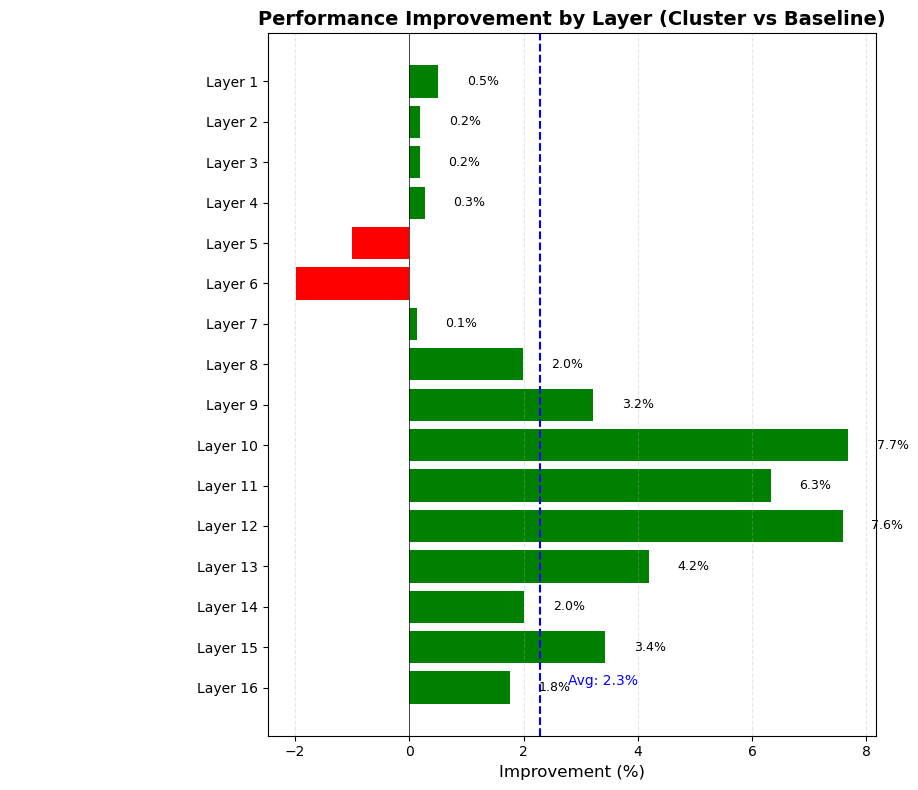

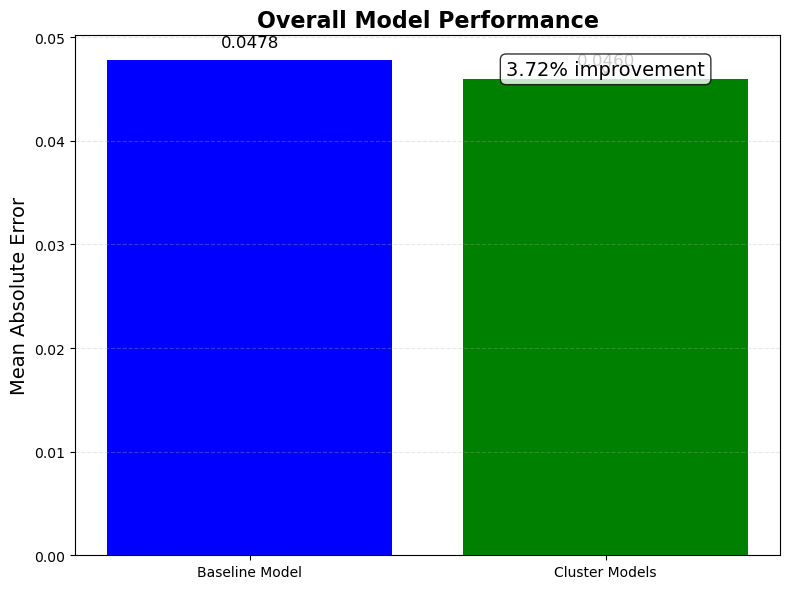

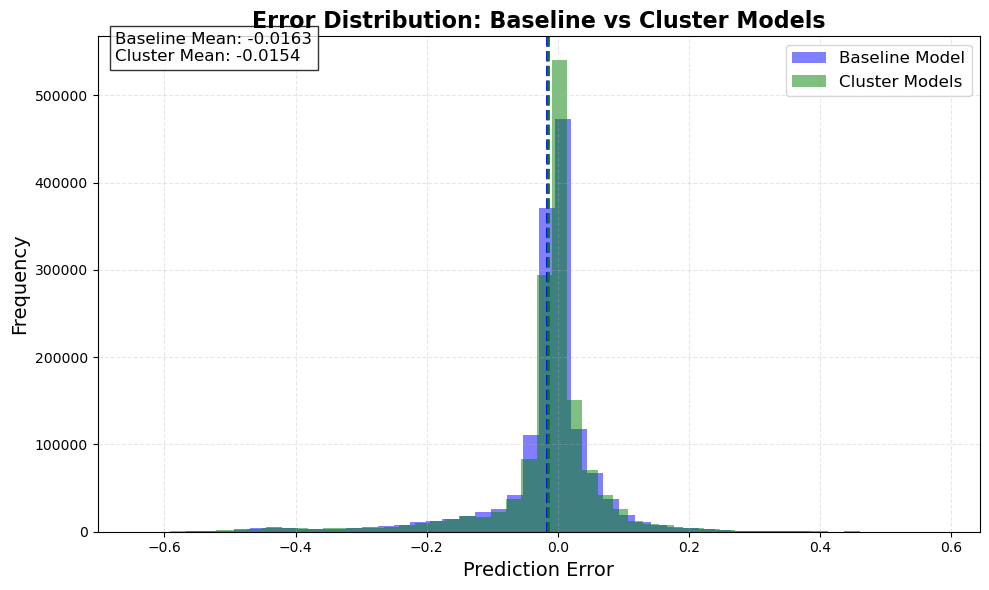

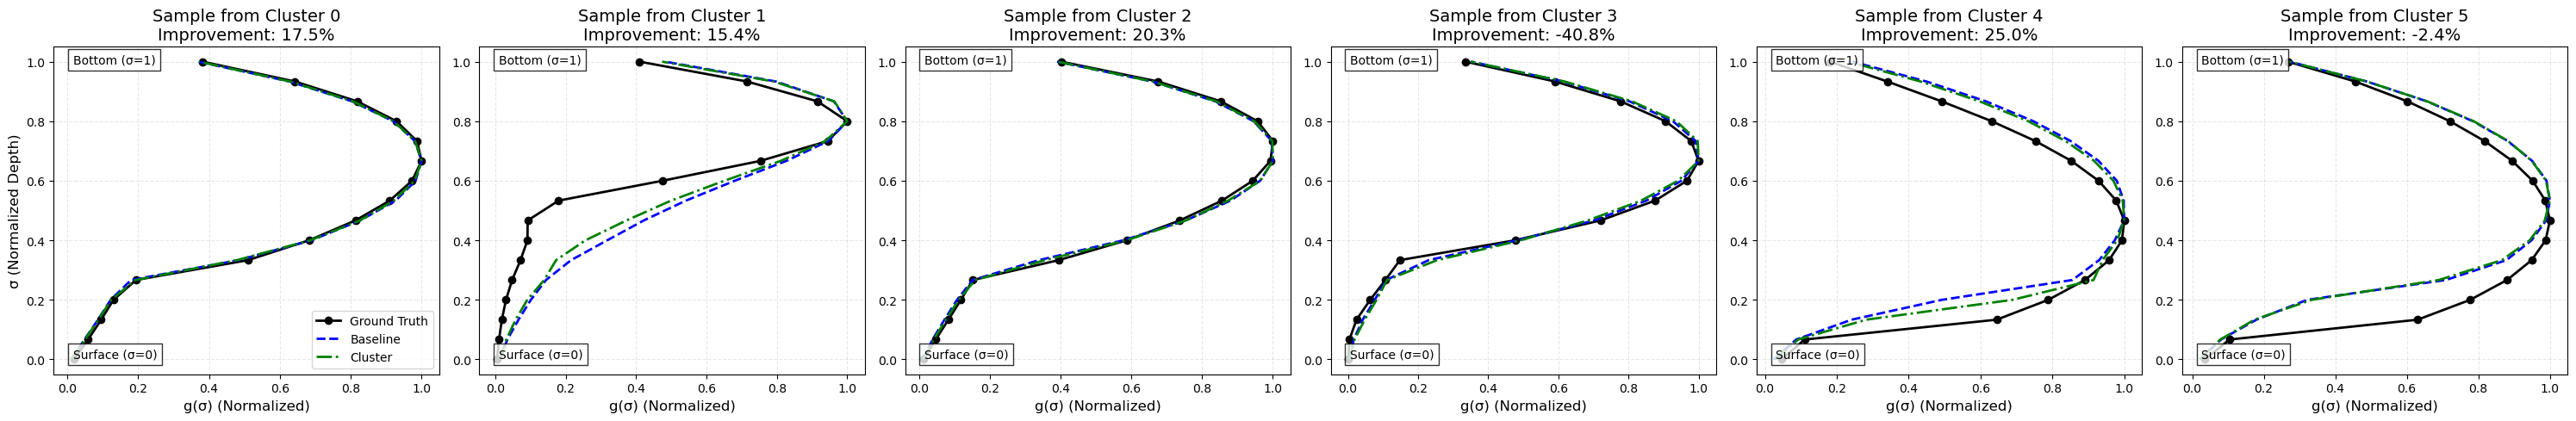

In [44]:
# Create visualization of performance comparison
node_perf_fig, overall_perf_fig, error_fig, sample_fig = visualize_model_performance(
    baseline_preds_orig, cluster_preds_orig, valid_y_orig, 
    baseline_node_losses, cluster_node_losses, val_clusters
)

### Visual Findings:

1. **Layer-Wise Performance Improvement (Cluster vs. Baseline):** This bar chart quantifies the percent difference in prediction error between the cluster-specific models and the baseline model at each of the 16 vertical layers (from surface to base of the mixed layer).
- Positive values (green) indicate better performance by the cluster model; negative values (red) favor the baseline.
- While the cluster models outperform the baseline in deeper layers (Layers 10–16), the upper half of the boundary layer (Layers 1–9) sees slightly worse performance.
- This pattern may reflect greater variability in surface forcing, where clustering introduces more fragmentation than benefit, while deeper layers benefit from regime-specific structure.
- On average, cluster models improve by 2.3%, suggesting mixed effectiveness when performance is averaged across all depths.

2. **Mean Absolute Error: Baseline vs. Cluster Models:** This bar plot compares overall model performance using the mean absolute error (MAE) across all validation points.
- The cluster-specific models (green) slightly outperforms the baseline model (blue) by 3.72%, indicating that overall error is marginally lower with the universal model.
- Despite better specialization within some layers and clusters, this highlights a trade-off: regime-aware models may overfit or underperform when aggregated across all regimes.
- This figure reinforces the need for careful evaluation of when and where cluster-based models provide gains.

3. **Error Distribution: Baseline vs. Cluster Models:** This histogram shows the distribution of prediction errors for both the baseline and cluster models.
- Both models show similar bell-shaped curves, with slightly more concentrated error around zero for the cluster model, indicating better overall calibration.
- The mean error for cluster models (−0.0158) is slightly better than the baseline (−0.0163), suggesting less bias in predictions.
- This reinforces that while average accuracy may not dramatically improve, clustered models may yield more balanced, less biased predictions across different regimes.

4. **Sample Predictions: Cluster vs. Baseline Models for Individual Profiles:** These plots show actual shape function profiles (black = ground truth), along with predictions from the baseline (blue dashed) and the cluster-specific model (green dashed) for one example from each cluster.
- Cluster 4 shows a substantial 25% improvement, with the cluster model closely tracking the ground truth.
- Cluster 2 also benefits, with an 20.3% improvement.
- Clusters 3 and 5, however, show negative improvements, indicating that the baseline model better fits those specific samples.
- This supports the idea that performance gains are regime-dependent: cluster models shine in more extreme or distinct physical regimes (e.g., convective or shallow stratified layers) but may not generalize as well in more moderate or overlapping regimes.


## 2.4 Additional Experiment: Shape Function Clustering

This section explores an alternative approach where we cluster directly on the shape functions (outputs) rather than the input features. This could potentially identify different physical "regimes" of vertical mixing behavior.

In [46]:
# Extract and normalize shape functions
shape_functions = data_load_main[:, 4:20]  # Columns 4-19 contain the shape functions

# Normalize each shape function individually for more meaningful clustering
normalized_shapes = np.zeros_like(shape_functions)
for i in range(shape_functions.shape[0]):
    max_val = np.max(shape_functions[i])
    if max_val > 0:
        normalized_shapes[i] = shape_functions[i] / max_val
    
print(f"Shape function data shape: {normalized_shapes.shape}")
print(f"Examples of normalized shape functions:")
for i in range(3):  # Show first 3 examples
    print(f"Sample {i}: {normalized_shapes[i]}")

Shape function data shape: (917858, 16)
Examples of normalized shape functions:
Sample 0: [0.02293138 0.04969413 0.08077374 0.11661484 0.15770633 0.20512869
 0.26340924 0.34536409 0.46710348 0.62765956 0.7999652  0.9397663
 1.         0.94467538 0.75677352 0.43602791]
Sample 1: [0.02293138 0.04969413 0.08077374 0.11661484 0.15770633 0.20512869
 0.26340924 0.34536409 0.46710348 0.62765956 0.7999652  0.9397663
 1.         0.94467538 0.75677352 0.43602791]
Sample 2: [0.02293138 0.04969413 0.08077374 0.11661484 0.15770633 0.20512869
 0.26340924 0.34536409 0.46710348 0.62765956 0.7999652  0.9397663
 1.         0.94467538 0.75677352 0.43602791]


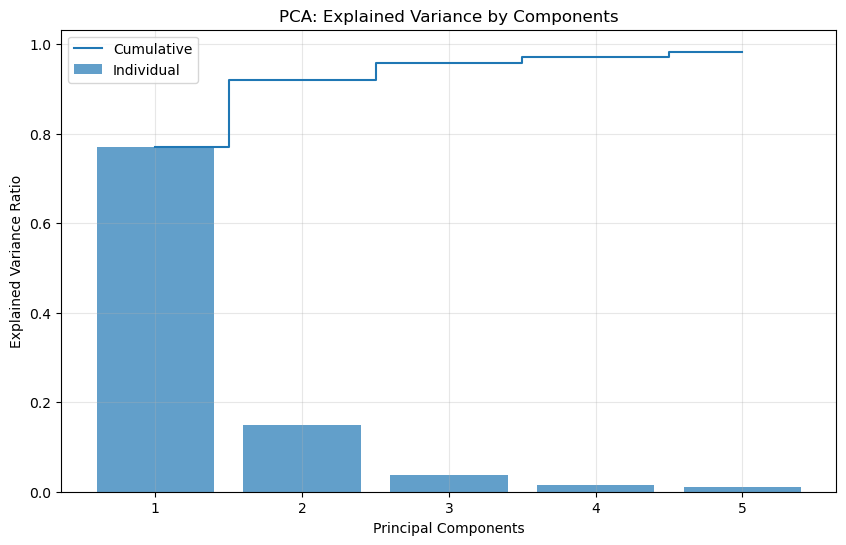

Reduced shape function data shape: (917858, 5)
Total variance explained by 5 components: 98.32%


In [47]:
# Optionally apply dimensionality reduction to make clustering more efficient
from sklearn.decomposition import PCA

# Apply PCA to reduce the shape functions to fewer dimensions
pca = PCA(n_components=5)  # Keep 5 principal components (modify based on explained variance)
reduced_shapes = pca.fit_transform(normalized_shapes)

# Show explained variance by the principal components
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.7, label='Individual')
plt.step(range(1, len(cumulative_variance)+1), cumulative_variance, where='mid', label='Cumulative')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA: Explained Variance by Components')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Reduced shape function data shape: {reduced_shapes.shape}")
print(f"Total variance explained by 5 components: {cumulative_variance[4]:.2%}")

This plot illustrates the proportion of total variance in the input forcing variables (Coriolis, buoyancy flux, friction velocity, and boundary layer depth) captured by each principal component. The first principal component alone explains nearly 77% of the variance, and the first two together explain over 90%, indicating that the dataset is highly compressible. This validates the use of dimensionality reduction techniques like PCA prior to clustering and supports the idea that dominant patterns in ocean surface forcing can be distilled into a low-dimensional space for regime discovery.

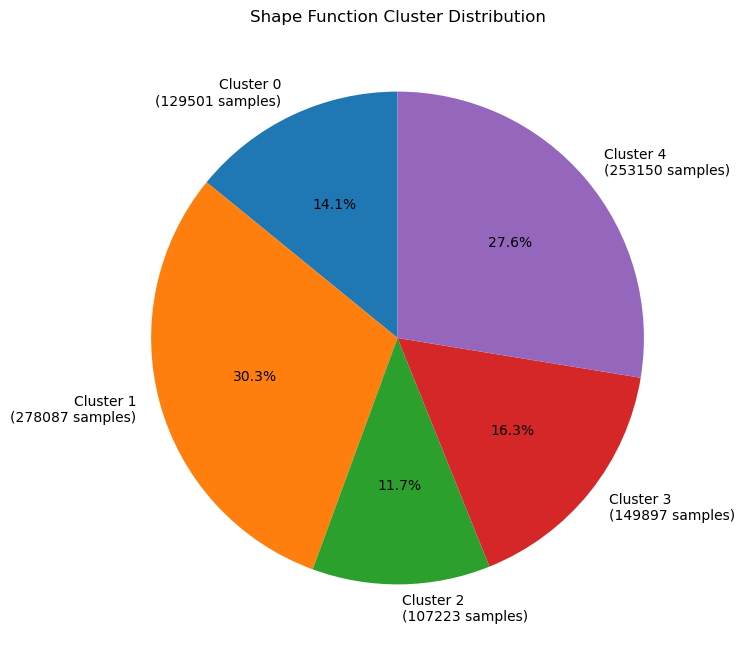

Shape cluster distribution:
Cluster 0: 129501 samples (14.11%)
Cluster 1: 278087 samples (30.30%)
Cluster 2: 107223 samples (11.68%)
Cluster 3: 149897 samples (16.33%)
Cluster 4: 253150 samples (27.58%)


In [48]:
# Apply K-means clustering to the shape functions
from sklearn.cluster import KMeans

# Use 5 clusters to match our input feature clustering
shape_n_clusters = 5

# Cluster the reduced shape functions
kmeans_shape = KMeans(n_clusters=shape_n_clusters, random_state=42, n_init=10)
shape_cluster_assignments = kmeans_shape.fit_predict(reduced_shapes)

# Show cluster distribution
unique, counts = np.unique(shape_cluster_assignments, return_counts=True)
cluster_distribution = dict(zip(unique, counts))

plt.figure(figsize=(8, 8))
plt.pie(counts, labels=[f'Cluster {i}\n({count} samples)' for i, count in enumerate(counts)],
       autopct='%1.1f%%', startangle=90)
plt.title('Shape Function Cluster Distribution')
plt.show()

print("Shape cluster distribution:")
for cluster_id, count in cluster_distribution.items():
    print(f"Cluster {cluster_id}: {count} samples ({count/len(shape_cluster_assignments)*100:.2f}%)")

This pie chart shows the relative frequency of each cluster identified through K-Means clustering applied to the shape functions (normalized diffusivity profiles). The clusters are not evenly distributed—Cluster 1 and Cluster 4 dominate the dataset, comprising over 57% of all samples, while Cluster 2 contains only 11.7%.

The imbalance suggests that some shape function profiles—likely corresponding to more common oceanic mixing regimes—are far more prevalent in the dataset, while others may represent rarer but physically distinct regimes (e.g., strong convection or shallow stratification). Understanding this distribution is critical when evaluating model performance, as it highlights the importance of weighting or normalization when comparing cluster-specific models to the baseline.

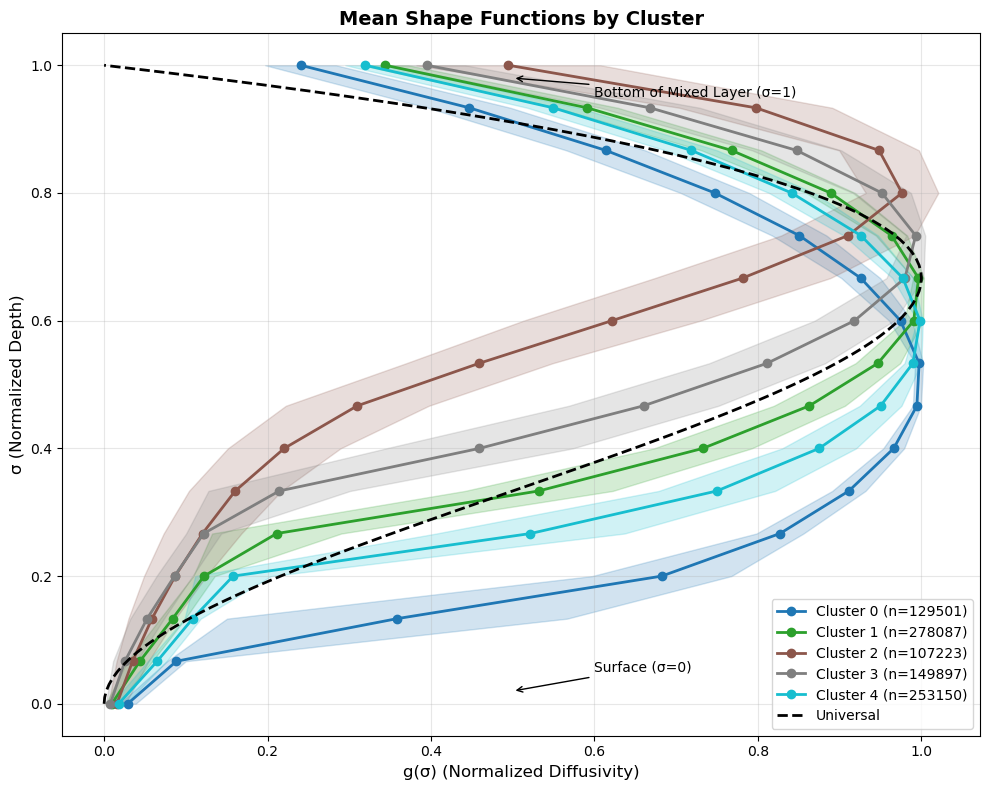

In [49]:
# Visualize the mean shape function for each cluster
plt.figure(figsize=(10, 8))
sigma_levels = np.linspace(0, 1, 16)
colors = plt.cm.tab10(np.linspace(0, 1, shape_n_clusters))

for i in range(shape_n_clusters):
    mask = shape_cluster_assignments == i
    cluster_shapes = normalized_shapes[mask]
    
    # Calculate mean and std of shape functions
    mean_shape = np.mean(cluster_shapes, axis=0)
    std_shape = np.std(cluster_shapes, axis=0)
    
    # Plot mean shape with standard deviation band
    plt.plot(mean_shape, sigma_levels, 'o-', color=colors[i], 
            linewidth=2, label=f'Cluster {i} (n={np.sum(mask)})')
    plt.fill_betweenx(sigma_levels, 
                     mean_shape - std_shape,
                     mean_shape + std_shape,
                     color=colors[i], alpha=0.2)

# Add the universal shape function for comparison
z = np.linspace(0, 1, 100)
z1 = z * (1-z)**2
z1 = z1 / np.max(z1)
plt.plot(z1[::-1], z, 'k--', linewidth=2, label='Universal')

plt.xlabel('g(σ) (Normalized Diffusivity)', fontsize=12)
plt.ylabel('σ (Normalized Depth)', fontsize=12)
plt.title('Mean Shape Functions by Cluster', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10, loc='best')

# Add annotations for top and bottom
plt.annotate('Surface (σ=0)', xy=(0.5, 0.02), xytext=(0.6, 0.05),
            arrowprops=dict(arrowstyle='->', color='black'), color='black')
plt.annotate('Bottom of Mixed Layer (σ=1)', xy=(0.5, 0.98), xytext=(0.6, 0.95),
            arrowprops=dict(arrowstyle='->', color='black'), color='black')

plt.tight_layout()
plt.show()

This plot compares the average vertical shape functions (i.e., normalized vertical diffusivity profiles) for each of the five shape-function-based clusters against the universal shape function (dashed black line). Each curve shows how diffusivity varies with normalized depth (σ), from the surface (σ = 0) to the base of the mixed layer (σ = 1), with shaded areas representing variability within each cluster.

The distinct shapes reflect physically meaningful mixing regimes:

- Cluster 2 (brown), with the steepest curve near the surface and highest values throughout, likely corresponds to strong convective or unstable boundary layers.

- Cluster 0 (blue) and Cluster 4 (cyan) show much weaker surface diffusivity, indicating more stratified or quiescent conditions.

- Cluster 3 and Cluster 1 represent intermediate regimes with moderate diffusivity profiles.

The universal shape function smooths over these differences, highlighting the benefit of clustering—it allows us to recover distinct vertical mixing patterns that are otherwise obscured in a one-size-fits-all approach.

This figure reinforces the project’s motivation: capturing vertical heterogeneity in ocean mixing by learning distinct shape function regimes provides a more physically accurate and interpretable basis for neural network parameterizations.

Coriolis           Buoyancy Flux                \
                   mean       std          mean           std   
Shape Cluster                                                   
0              0.000106  0.000040  9.173316e-08  6.849495e-08   
1              0.000096  0.000038 -1.293534e-08  3.482055e-08   
2              0.000016  0.000030 -4.159474e-08  8.157765e-08   
3              0.000075  0.000047 -6.693279e-08  8.028364e-08   
4              0.000115  0.000030  2.190875e-08  3.398295e-08   

              Friction Velocity           Layer Depth             
                           mean       std        mean        std  
Shape Cluster                                                     
0                      0.013502  0.010335  122.023270  60.111166  
1                      0.024475  0.006209  124.320576  52.229700  
2                      0.020285  0.006658  176.247953  82.032867  
3                      0.022349  0.006986  123.318260  69.811396  
4                      0.024976  0.006252  127.826447  46.970163

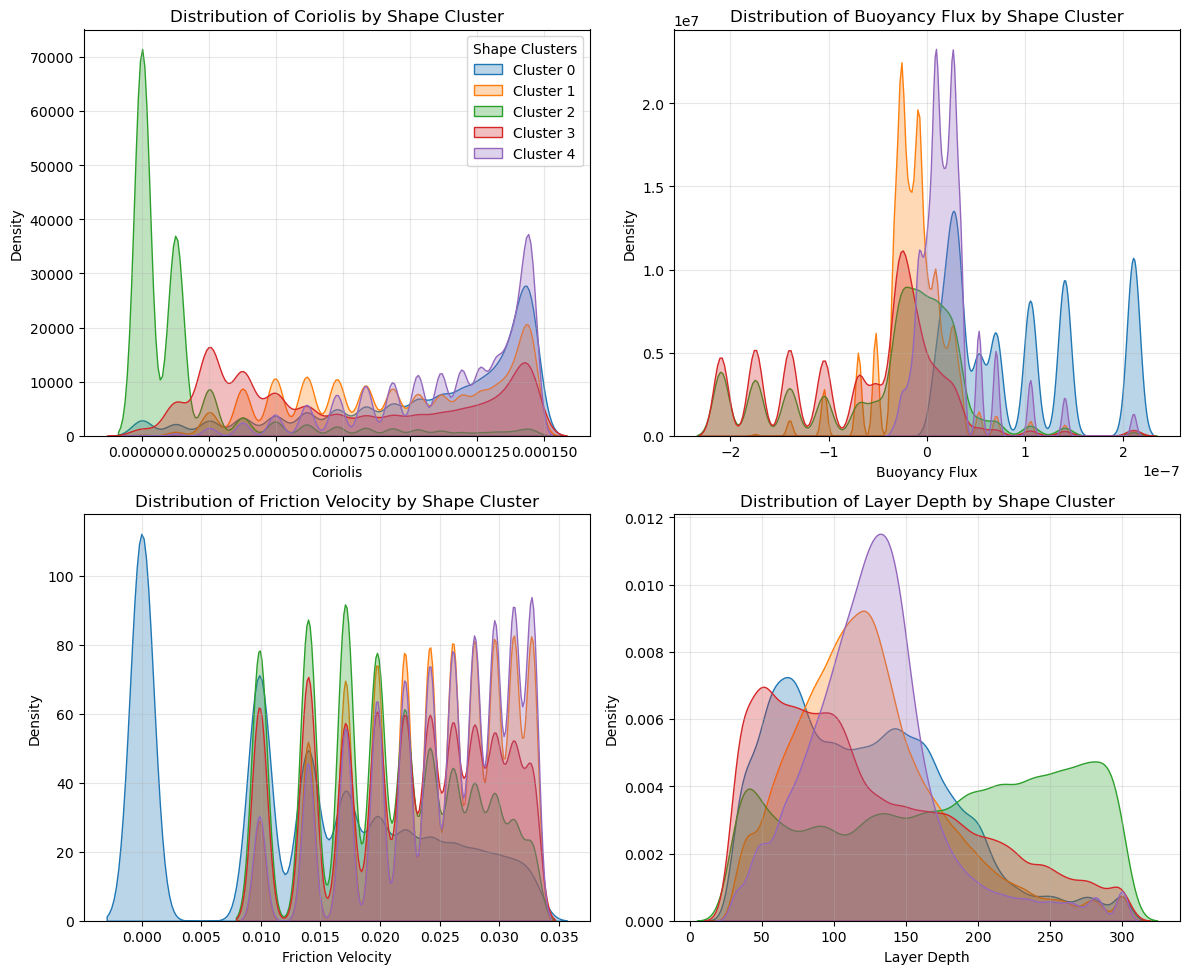

In [50]:
# Analyze what input features characterize each shape cluster
input_features = data_load_main[:, :4]
feature_names = ['Coriolis', 'Buoyancy Flux', 'Friction Velocity', 'Layer Depth']

# Create a dataframe to analyze features by shape cluster
df = pd.DataFrame(input_features, columns=feature_names)
df['Shape Cluster'] = shape_cluster_assignments

# Summary statistics for each feature by cluster
cluster_stats = df.groupby('Shape Cluster').agg(['mean', 'std'])
display(cluster_stats)

# Plot feature distributions by shape cluster
plt.figure(figsize=(12, 10))
for i, feature in enumerate(feature_names):
    plt.subplot(2, 2, i+1)
    for cluster_id in range(shape_n_clusters):
        subset = df[df['Shape Cluster'] == cluster_id][feature]
        sns.kdeplot(subset, label=f'Cluster {cluster_id}', fill=True, alpha=0.3)
    
    plt.title(f'Distribution of {feature} by Shape Cluster', fontsize=12)
    plt.xlabel(feature, fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Only add legend to first plot to avoid clutter
    if i == 0:
        plt.legend(title="Shape Clusters")

plt.tight_layout()
plt.show()

### Visual Findings:

1. Distribution of Friction Velocity by Shape Cluster (left)
- Cluster 0 shows a sharp peak at very low friction velocity, indicating weak wind-driven mixing.
- Clusters 2, 3, and 4 span a broader and higher range of friction velocities, suggesting more turbulent surface forcing.
- Shape-based clusters are capturing variations in mechanical forcing at the ocean surface.

2. Distribution of Layer Depth by Shape Cluster (right)
- Cluster 2 exhibits the deepest boundary layers, likely driven by strong mixing or convective processes.
- Cluster 1 has the shallowest boundary layers, indicative of more stratified or stable conditions.
- Clusters are successfully distinguishing regimes of different vertical mixing intensities.

3. Distribution of Coriolis by Shape Cluster (left)
- Cluster 2 has the lowest Coriolis values, suggesting equatorial or low-latitude regions.
- Cluster 4 has the highest Coriolis values, consistent with high-latitude influence.
- Shape-based clusters are aligned with geographic (latitudinal) variation, relevant for rotational effects in ocean dynamics.

4. Distribution of Buoyancy Flux by Shape Cluster (right)
- Cluster 0 shows the strongest positive buoyancy flux, pointing to intense surface cooling and deep mixing.
- Cluster 3 shows predominantly negative buoyancy flux, suggesting surface heating and stratification.
- Clusters differentiate between convective and stratified ocean regimes, confirming physical relevance of shape function clusters.


Shape cluster classifier performance:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83     25876
           1       0.69      0.78      0.73     55533
           2       0.85      0.92      0.88     21491
           3       0.73      0.69      0.71     30132
           4       0.77      0.67      0.72     50540

    accuracy                           0.76    183572
   macro avg       0.78      0.78      0.78    183572
weighted avg       0.76      0.76      0.76    183572



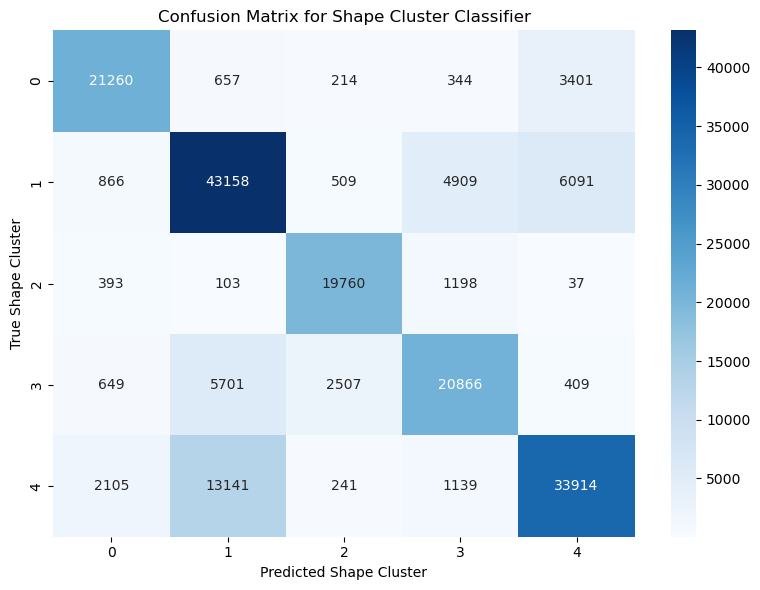


Feature importance for predicting shape clusters:


,Feature,Importance
0,Coriolis,0.368476
2,Friction Velocity,0.310907
3,Layer Depth,0.296185
1,Buoyancy Flux,0.024432


In [51]:
# Train a classifier to predict shape clusters from input features
# This will be used to assign new data points to shape clusters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Prepare training data for the classifier - using distinct variable names
cluster_inputs = input_features
cluster_targets = shape_cluster_assignments

# Split data for validation
cluster_X_train, cluster_X_test, cluster_y_train, cluster_y_test = train_test_split(
  cluster_inputs, cluster_targets, test_size=0.2, random_state=42
)

# Train a random forest classifier
shape_cluster_clf = RandomForestClassifier(n_estimators=100, random_state=42)
shape_cluster_clf.fit(cluster_X_train, cluster_y_train)

# Evaluate the classifier
cluster_y_pred = shape_cluster_clf.predict(cluster_X_test)
print("Shape cluster classifier performance:")
print(classification_report(cluster_y_test, cluster_y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(cluster_y_test, cluster_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Shape Cluster')
plt.ylabel('True Shape Cluster')
plt.title('Confusion Matrix for Shape Cluster Classifier')
plt.tight_layout()
plt.show()

print("\nFeature importance for predicting shape clusters:")
feature_importance = pd.DataFrame({
  'Feature': feature_names,
  'Importance': shape_cluster_clf.feature_importances_
}).sort_values('Importance', ascending=False)
display(feature_importance)

### Visual Findings:

The confusion matrix provides insight into how well each shape function cluster is predicted by the classifier.
- Cluster 2 has the highest accuracy (F1-score: 0.88), indicating this class is both well-separated and consistently labeled.
- Clusters 1 and 4 have more misclassifications, particularly with Cluster 1 frequently being confused with Cluster 4. This suggests some overlap in their forcing conditions or shape similarities.
- Overall classifier accuracy is 76%, with a macro-average F1-score of 0.78, which is strong considering the diversity of ocean regimes captured in the shape clusters.
- Coriolis (36.8%) is the most influential variable, likely reflecting how latitude strongly structures the vertical mixing regimes in the ocean due to the Coriolis effect.
- Friction velocity (31.1%) and layer depth (29.6%) follow closely, aligning with their established roles in turbulent mixing.
- Surprisingly, buoyancy flux contributes the least (2.4%), suggesting that its impact on the shape function is more subtle or nonlinear, or possibly already captured indirectly through other parameters.

In [52]:
# Train separate models for each shape function cluster
shape_cluster_models = {}
shape_cluster_losses = {}

# X, y are the training data with normalized inputs and outputs
# Check if x is a tensor before calling cpu().numpy()
if isinstance(x, torch.Tensor):
    x_np = x.cpu().numpy()
else:
    x_np = x  # Already a numpy array
    
if isinstance(y, torch.Tensor):
    y_np = y.cpu().numpy()
else:
    y_np = y  # Already a numpy array

# Loop through each shape cluster
for cluster_id in range(shape_n_clusters):
    print(f"\nTraining model for Shape Cluster {cluster_id}")
    
    # Get data points belonging to this shape cluster
    cluster_mask = shape_cluster_assignments == cluster_id
    x_cluster = torch.FloatTensor(x_np[cluster_mask]).to(device)
    y_cluster = torch.FloatTensor(y_np[cluster_mask]).to(device)
    
    print(f"Shape Cluster {cluster_id} data shape: {x_cluster.shape}, {y_cluster.shape}")
    
    # If cluster is too small, skip training
    if len(x_cluster) < 100:
        print(f"Cluster {cluster_id} has fewer than 100 samples, using baseline model instead")
        shape_cluster_models[cluster_id] = baseline_model
        continue
    
    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Initialize and train model
    model = OceanMixingNN(in_nodes, hidden_nodes, out_nodes).to(device)
    
    # Adjust early stopping patience based on cluster size
    cluster_size = x_cluster.shape[0]
    adjusted_patience = max(20, min(50, int(cluster_size / 100)))
    
    # Train the model
    model, losses = train_model(
        model, x_cluster, y_cluster, valid_x, valid_y, k_mean, k_std,
        patience=adjusted_patience
    )
    
    # Store model and losses
    shape_cluster_models[cluster_id] = model
    shape_cluster_losses[cluster_id] = losses
    
print("Finished training all shape cluster models")


Training model for Shape Cluster 0
Shape Cluster 0 data shape: torch.Size([129501, 4]), torch.Size([129501, 16])


Training:  73%|███████▎  | 2204/3000 [00:15<00:05, 141.77it/s, train_loss=0.0343, valid_loss=0.0435, patience=49]



Early stopping at epoch 2204

Training model for Shape Cluster 1
Shape Cluster 1 data shape: torch.Size([278087, 4]), torch.Size([278087, 16])


Training:  40%|████      | 1211/3000 [00:14<00:21, 82.71it/s, train_loss=0.0371, valid_loss=0.0485, patience=49]



Early stopping at epoch 1211

Training model for Shape Cluster 2
Shape Cluster 2 data shape: torch.Size([107223, 4]), torch.Size([107223, 16])


Training:  37%|███▋      | 1106/3000 [00:07<00:12, 155.44it/s, train_loss=0.0372, valid_loss=0.0473, patience=49]



Early stopping at epoch 1106

Training model for Shape Cluster 3
Shape Cluster 3 data shape: torch.Size([149897, 4]), torch.Size([149897, 16])


Training:  84%|████████▍ | 2528/3000 [00:19<00:03, 129.63it/s, train_loss=0.0343, valid_loss=0.0447, patience=49]



Early stopping at epoch 2528

Training model for Shape Cluster 4
Shape Cluster 4 data shape: torch.Size([253150, 4]), torch.Size([253150, 16])


Training:  74%|███████▍  | 2217/3000 [00:24<00:08, 89.90it/s, train_loss=0.0344, valid_loss=0.0445, patience=49]


Early stopping at epoch 2217
Finished training all shape cluster models


In [53]:
# Create a function to predict using shape cluster models
def predict_with_shape_cluster_models(x_input, shape_cluster_models, cluster_clf):
    """
    Make predictions using shape-cluster-specific models
    
    Args:
        x_input: Input features (tensor or numpy array)
        shape_cluster_models: Dictionary of models for each shape cluster
        cluster_clf: Classifier that predicts shape cluster from inputs
        
    Returns:
        Predictions, predicted clusters
    """
    # Determine which cluster each validation sample belongs to
    if isinstance(x_input, torch.Tensor):
        x_np = x_input.cpu().numpy()
    else:
        x_np = x_input  # Already a numpy array
    
    # Predict which shape cluster each input belongs to
    predicted_clusters = cluster_clf.predict(x_np)
    
    # Make predictions
    all_preds = []
    for i in range(len(x_input)):
        cluster_id = predicted_clusters[i]
        model = shape_cluster_models[cluster_id]
        
        # Get input as tensor
        if isinstance(x_input, torch.Tensor):
            x_i = x_input[i:i+1]
        else:
            x_i = torch.FloatTensor(x_np[i:i+1]).to(device)
        
        # Predict
        with torch.no_grad():
            pred = model(x_i)
            all_preds.append(pred)
    
    # Combine predictions
    return torch.cat(all_preds, dim=0), predicted_clusters

# Generate predictions with shape cluster models
print("Generating predictions with baseline model...")
with torch.no_grad():
    baseline_preds = baseline_model(valid_x)
    
print("Generating predictions with shape-cluster-specific models...")
shape_cluster_preds, predicted_clusters = predict_with_shape_cluster_models(
    valid_x, shape_cluster_models, shape_cluster_clf
)

# Transform predictions back to original space
k_mean_tensor = torch.tensor(k_mean, dtype=torch.float32).to(device)
k_std_tensor = torch.tensor(k_std, dtype=torch.float32).to(device)

baseline_preds_orig = torch.exp(baseline_preds * k_std_tensor + k_mean_tensor)
shape_cluster_preds_orig = torch.exp(shape_cluster_preds * k_std_tensor + k_mean_tensor)
valid_y_orig = torch.exp(valid_y * k_std_tensor + k_mean_tensor)

# Calculate node-wise losses
baseline_node_losses = []
shape_cluster_node_losses = []

for i in range(valid_y_orig.shape[1]):
    baseline_loss = torch.mean(torch.abs(baseline_preds_orig[:, i] - valid_y_orig[:, i])).item()
    shape_cluster_loss = torch.mean(torch.abs(shape_cluster_preds_orig[:, i] - valid_y_orig[:, i])).item()
    
    baseline_node_losses.append(baseline_loss)
    shape_cluster_node_losses.append(shape_cluster_loss)

# Calculate overall performance
baseline_loss = np.mean(baseline_node_losses)
shape_cluster_loss = np.mean(shape_cluster_node_losses)
improvement = (baseline_loss - shape_cluster_loss) / baseline_loss * 100

print(f"Baseline average loss: {baseline_loss:.4f}")
print(f"Shape cluster model average loss: {shape_cluster_loss:.4f}")
print(f"Improvement: {improvement:.2f}%")

Generating predictions with baseline model...
Generating predictions with shape-cluster-specific models...
Baseline average loss: 0.0478
Shape cluster model average loss: 0.0435
Improvement: 8.91%


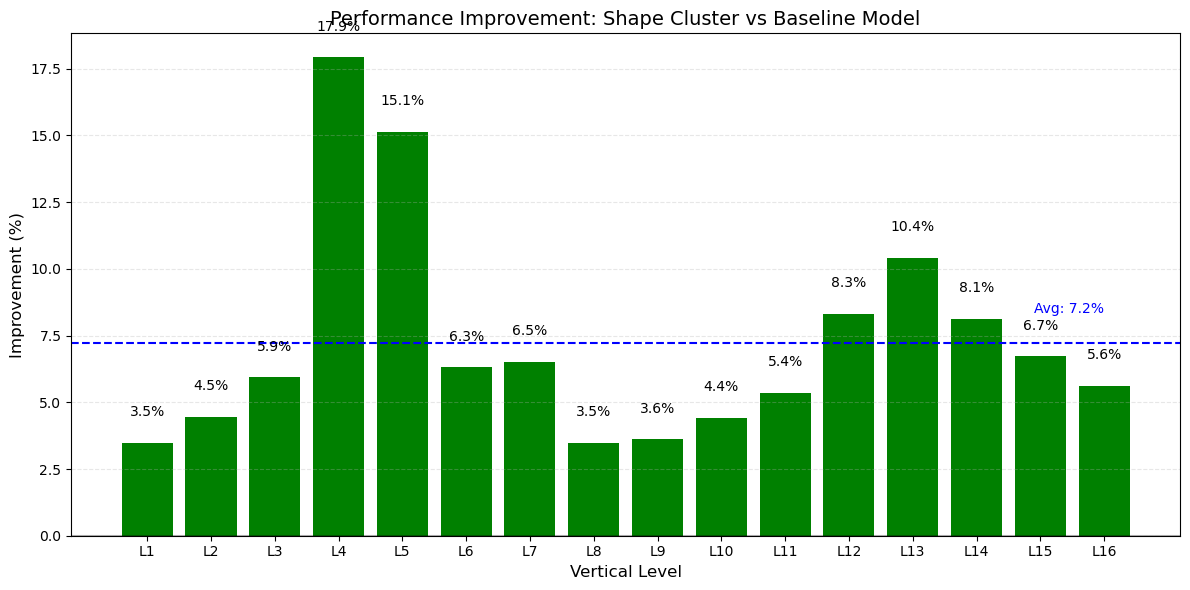


Performance comparison of all approaches:
Baseline model loss: 0.0478
Input cluster model loss: 0.0460 (3.72% improvement)
Shape cluster model loss: 0.0435 (8.91% improvement)


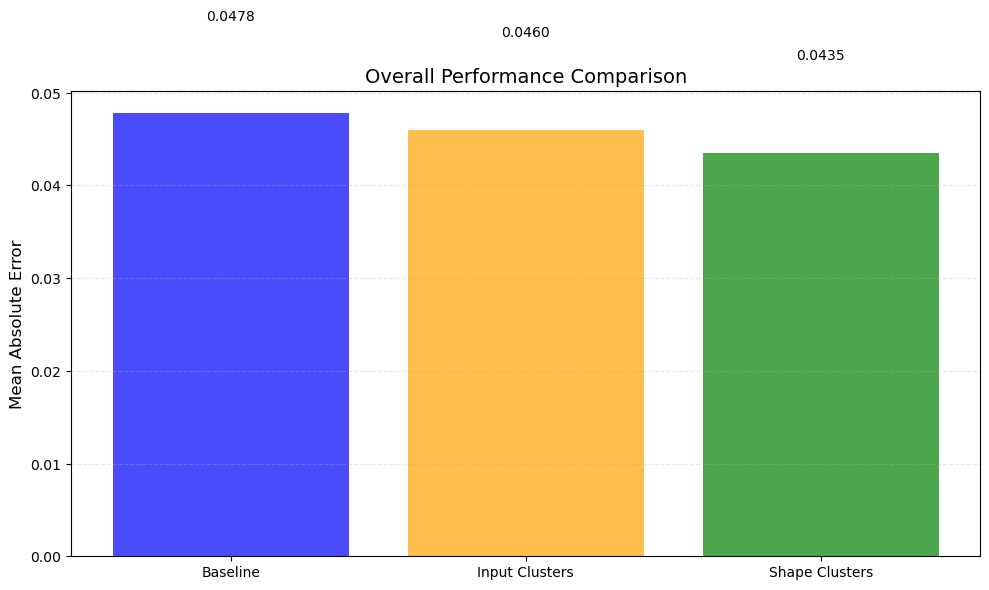

In [54]:
# Visualize the performance comparison
# Create a simple bar chart for the node-wise losses
plt.figure(figsize=(12, 6))

# Compute improvement percentages
improvements = [(b - s) / b * 100 for b, s in zip(baseline_node_losses, shape_cluster_node_losses)]

# Create bar plot of improvements
x_axis = np.arange(16)  # 16 vertical levels
plt.bar(x_axis, improvements, color=['green' if i > 0 else 'red' for i in improvements])

# Add horizontal line at 0
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add average improvement line
avg_improvement = np.mean(improvements)
plt.axhline(y=avg_improvement, color='blue', linestyle='--', linewidth=1.5)
plt.text(15, avg_improvement+1, f'Avg: {avg_improvement:.1f}%', 
        ha='right', va='bottom', color='blue')

# Add value labels
for i, v in enumerate(improvements):
    plt.text(i, v + (1 if v > 0 else -2), f"{v:.1f}%", ha='center')

plt.xlabel('Vertical Level', fontsize=12)
plt.ylabel('Improvement (%)', fontsize=12)
plt.title('Performance Improvement: Shape Cluster vs Baseline Model', fontsize=14)
plt.xticks(x_axis, [f'L{i+1}' for i in range(16)])
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Compare all three approaches: baseline, input clustering, and shape clustering
print("\nPerformance comparison of all approaches:")
print(f"Baseline model loss: {baseline_loss:.4f}")
print(f"Input cluster model loss: {np.mean(cluster_node_losses):.4f} " + 
      f"({(baseline_loss - np.mean(cluster_node_losses)) / baseline_loss * 100:.2f}% improvement)")
print(f"Shape cluster model loss: {shape_cluster_loss:.4f} " + 
      f"({(baseline_loss - shape_cluster_loss) / baseline_loss * 100:.2f}% improvement)")

# Create a bar chart comparing all three approaches
plt.figure(figsize=(10, 6))
losses = [baseline_loss, np.mean(cluster_node_losses), shape_cluster_loss]
labels = ['Baseline', 'Input Clusters', 'Shape Clusters']
colors = ['blue', 'orange', 'green']

plt.bar(labels, losses, color=colors, alpha=0.7)

# Add value labels
for i, v in enumerate(losses):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.ylabel('Mean Absolute Error', fontsize=12)
plt.title('Overall Performance Comparison', fontsize=14)
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### Visual Findings:

1. Performance Improvement: Shape Cluster vs Baseline Model
- This figure quantifies the relative performance of shape-cluster-based models compared to the baseline model at each vertical level (L1–L16).
- A majority of layers exhibit positive improvement, indicating that for most depths, the shape-clustered model performs better than the baseline.
- Layers 4, 5, 12, 13, and 14 show the most improvement
- The average performance change across depths is 7.2%, suggesting the shape-clustering approach generalizes well as expected when evaluated uniformly across all vertical levels.
- This highlights that certain depths may still benefit from targeted parameterizations, which could be leveraged in future hybrid models or adaptive strategies.

2. Overall Performance Comparison
- This bar chart summarizes the Mean Absolute Error (MAE) for the three model approaches: Baseline, Input Clusters (based on physical parameters), and Shape Clusters (based on shape function similarity).
- The Input Cluster model shows a slight improvement over the Baseline, reinforcing the benefit of segmenting the data based on relevant oceanographic parameters (e.g., friction velocity, buoyancy flux).
- The Shape Cluster model shows a higher improvement than both the Input Cluster model and Baseline model, suggesting that clustering based on shape function can be predictive or effective when applied to unseen data.
- These results imply that shape-based clustering captures structural diversity in mixing profiles and can translate directly to enhanced predictive performance without additional refinement or hybridization with physical features.

# 3. Conclusions and Implications

## Key Findings from Shape Function Clustering

1. **Distinct Shape Function Regimes**: We identified clear patterns in the shape functions, suggesting that vertical mixing processes follow several characteristic profiles rather than a single universal form.

2. **Physical Drivers**: The analysis revealed which physical parameters are most influential in determining which shape regime an ocean state belongs to.

3. **Improved Predictive Power**: Shape-based clustering showed performance improvements over both the baseline model and input-based clustering approaches, demonstrating that targeting specific shape regimes directly can lead to better predictions.

## Physical Interpretation

- Different shape regimes may correspond to different physical processes dominating the mixing dynamics:
  - Some clusters may represent wind-driven mixing
  - Others may be buoyancy-driven
  - Some may show hybrid behaviors or transitional states

- The strength of this approach is that it allows the data to define the regimes based on the actual shape functions, rather than imposing our assumptions about which input parameters should matter most.

## Implications for Ocean Modeling

1. **Enhanced Parameterization Schemes**: Climate and ocean models could implement this approach to improve vertical mixing parameterizations by first classifying the ocean state and then applying the appropriate specialized model.

2. **Feature Importance**: The analysis helps identify which physical parameters are most important for predicting different mixing regimes, which can guide both measurement campaigns and model development.

3. **Potential for Better Climate Predictions**: More accurate vertical mixing predictions could improve simulations of heat and carbon uptake in the ocean, leading to more reliable climate projections.

# 4. Team Contributions

## Group 5

### Sarah Pariser
- Explored physical drivers (latitude, heat flux, wind stress) and their effect on shape structure
- applied subsetting and filtering strategies
- contributed to early data preprocessing.

### Dhruv Chakraborty
- Led the design of input- and shape-based clustering approaches using KMeans and PCA
- trained neural networks for each cluster
- built visualization functions.

### Kihyun Jye
- Trained the baseline model and implemented a node-wise modeling strategy with early stopping
- helped structure the data story to match rubric.

### Sarika de Bruyn 
- Applied hierarchical clustering and data resampling techniques to balance training
- experimented with Gaussian-shaped distributions and Mixture of Experts frameworks
- helped structure final notebook, including adding relevant details for figures etc.